In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '/Users/rudra/Desktop/Projects/U-net/stage1_train/'
TEST_PATH = '/Users/rudra/Desktop/Projects/U-net/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        if not mask_file.endswith('.png'):
            continue  # Skip non-image files like .DS_Store
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_) 
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing training images and masks


100%|█████████████████████████████████████████| 670/670 [02:00<00:00,  5.57it/s]


Resizing test images


100%|███████████████████████████████████████████| 65/65 [00:00<00:00, 93.44it/s]

Done!


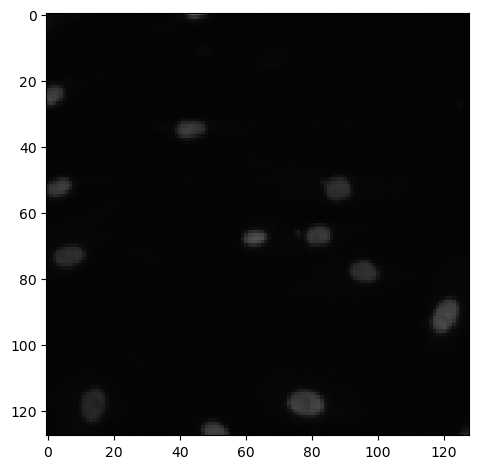

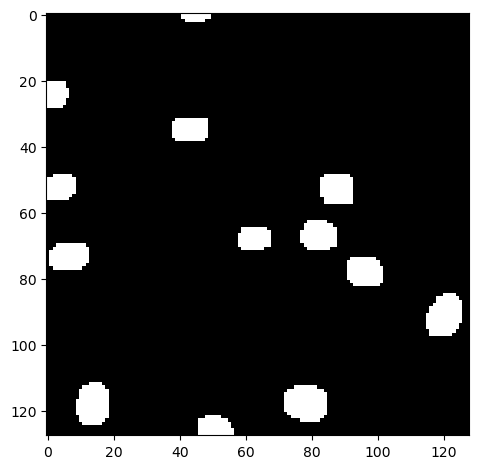

In [3]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [4]:
# building model
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# contracting path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# extracting path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

 conv2d_15 (Conv2D)          (None, 64, 64, 32)           9248      ['dropout_7[0][0]']           
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 16)         2064      ['conv2d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 32)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 128, 128, 16)         4624      ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8

In [5]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#         tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25)

Epoch 1/25
38/38 [==============================] - 15s 381ms/step - loss: 0.5753 - accuracy: 0.7678 - val_loss: 0.3614 - val_accuracy: 0.8105
Epoch 2/25
38/38 [==============================] - 14s 380ms/step - loss: 0.2837 - accuracy: 0.8743 - val_loss: 0.2115 - val_accuracy: 0.9144
Epoch 3/25
38/38 [==============================] - 15s 388ms/step - loss: 0.1851 - accuracy: 0.9285 - val_loss: 0.1416 - val_accuracy: 0.9455
Epoch 4/25
38/38 [==============================] - 15s 391ms/step - loss: 0.1480 - accuracy: 0.9435 - val_loss: 0.1550 - val_accuracy: 0.9359
Epoch 5/25
38/38 [==============================] - 15s 394ms/step - loss: 0.1357 - accuracy: 0.9481 - val_loss: 0.1165 - val_accuracy: 0.9552
Epoch 6/25
38/38 [==============================] - 17s 446ms/step - loss: 0.1245 - accuracy: 0.9535 - val_loss: 0.1129 - val_accuracy: 0.9565
Epoch 7/25
38/38 [==============================] - 20s 523ms/step - loss: 0.1192 - accuracy: 0.9545 - val_loss: 0.1162 - val_accuracy: 0.9564

3/3 [==============================] - 0s 94ms/step


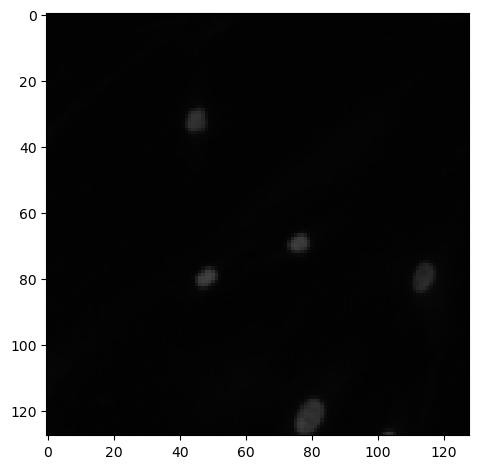

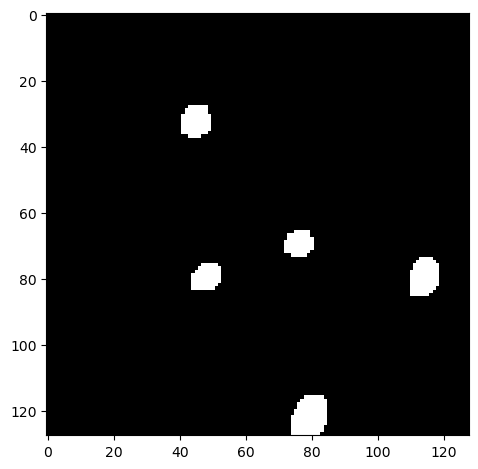

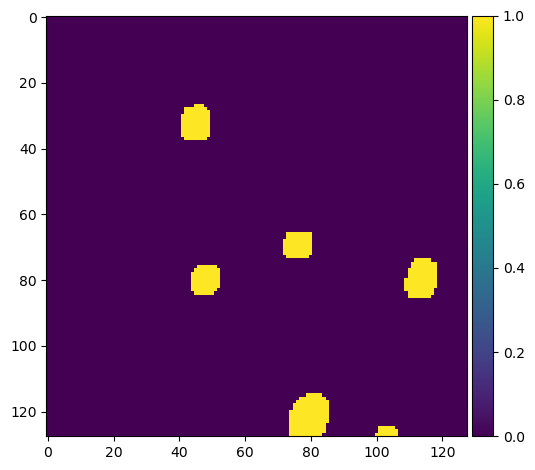

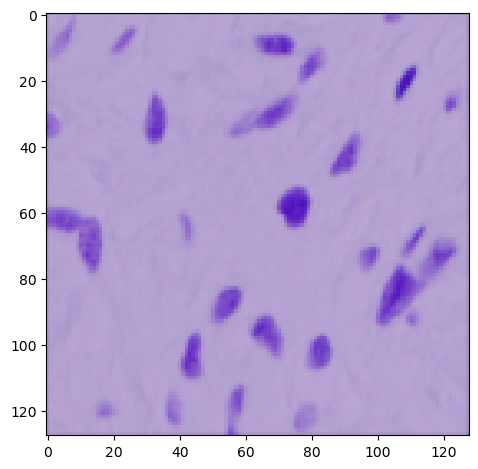

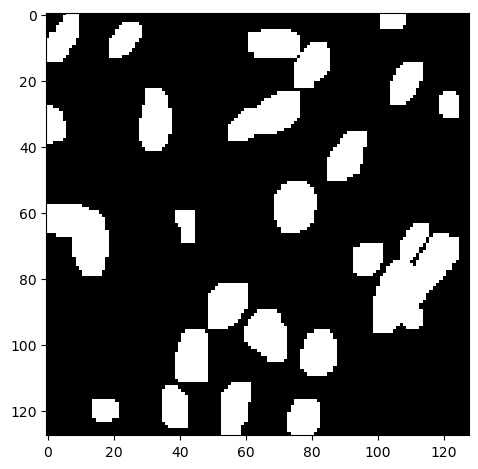

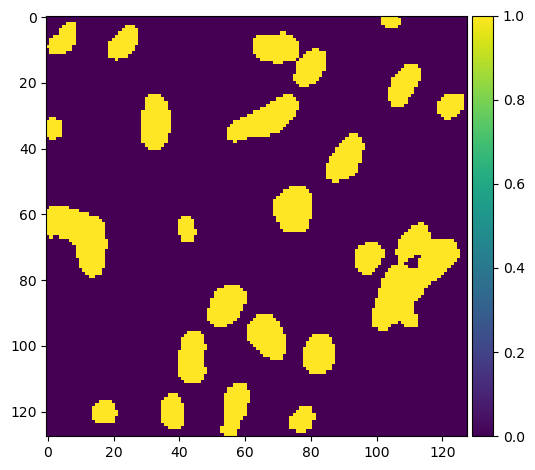

In [9]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [10]:
from sklearn.metrics import accuracy_score

# Assuming you have trained your U-Net model and have it stored in the 'model' variable

# Create empty arrays to store predicted masks and ground truth masks
predicted_masks = []
ground_truth_masks = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = X_train[n]  # Input image
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input shape
    mask = model.predict(img)  # Predict the mask

    # Threshold the predicted mask (assuming binary output)
    mask = (mask > 0.5).astype(np.uint8)

    predicted_masks.append(mask)
    ground_truth_masks.append(Y_train[n])

# Convert the lists of masks to numpy arrays
predicted_masks = np.array(predicted_masks)
ground_truth_masks = np.array(ground_truth_masks)

# Flatten the masks to 1D arrays
predicted_masks_flat = predicted_masks.reshape(-1)
ground_truth_masks_flat = ground_truth_masks.reshape(-1)

# Calculate the accuracy score
accuracy = accuracy_score(ground_truth_masks_flat, predicted_masks_flat)


  0%|                                                   | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▎                                          | 4/670 [00:00<00:18, 36.50it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▌                                          | 8/670 [00:00<00:18, 36.67it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▊                                         | 12/670 [00:00<00:17, 37.05it/s]

1/1 [==============================] - 0s 17ms/step


  2%|█                                         | 16/670 [00:00<00:17, 36.78it/s]

1/1 [==============================] - 0s 17ms/step


  3%|█▎                                        | 20/670 [00:00<00:17, 36.73it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▌                                        | 24/670 [00:00<00:17, 36.68it/s]

1/1 [==============================] - 0s 17ms/step


  4%|█▊                                        | 28/670 [00:00<00:17, 36.35it/s]

1/1 [==============================] - 0s 17ms/step


  5%|██                                        | 32/670 [00:00<00:17, 36.42it/s]

1/1 [==============================] - 0s 17ms/step


  5%|██▎                                       | 36/670 [00:00<00:17, 36.35it/s]

1/1 [==============================] - 0s 18ms/step


  6%|██▌                                       | 40/670 [00:01<00:17, 36.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|██▊                                       | 44/670 [00:01<00:17, 36.31it/s]

1/1 [==============================] - 0s 17ms/step


  7%|███                                       | 48/670 [00:01<00:17, 36.47it/s]

1/1 [==============================] - 0s 17ms/step


  8%|███▎                                      | 52/670 [00:01<00:16, 36.38it/s]

1/1 [==============================] - 0s 17ms/step


  8%|███▌                                      | 56/670 [00:01<00:16, 36.55it/s]

1/1 [==============================] - 0s 18ms/step


  9%|███▊                                      | 60/670 [00:01<00:16, 36.64it/s]

1/1 [==============================] - 0s 17ms/step


 10%|████                                      | 64/670 [00:01<00:16, 36.42it/s]

1/1 [==============================] - 0s 16ms/step


 10%|████▎                                     | 68/670 [00:01<00:16, 36.80it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████▌                                     | 72/670 [00:01<00:16, 37.34it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████▊                                     | 76/670 [00:02<00:15, 37.68it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█████                                     | 80/670 [00:02<00:15, 37.18it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▎                                    | 84/670 [00:02<00:15, 37.30it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█████▌                                    | 88/670 [00:02<00:15, 37.48it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█████▊                                    | 92/670 [00:02<00:15, 37.95it/s]

1/1 [==============================] - 0s 17ms/step


 14%|██████                                    | 96/670 [00:02<00:15, 37.84it/s]

1/1 [==============================] - 0s 16ms/step


 15%|██████                                   | 100/670 [00:02<00:15, 37.44it/s]

1/1 [==============================] - 0s 16ms/step


 16%|██████▎                                  | 104/670 [00:02<00:15, 37.32it/s]

1/1 [==============================] - 0s 18ms/step


 16%|██████▌                                  | 108/670 [00:02<00:15, 37.06it/s]

1/1 [==============================] - 0s 17ms/step


 17%|██████▊                                  | 112/670 [00:03<00:15, 37.19it/s]

1/1 [==============================] - 0s 15ms/step


 17%|███████                                  | 116/670 [00:03<00:14, 37.31it/s]

1/1 [==============================] - 0s 16ms/step


 18%|███████▎                                 | 120/670 [00:03<00:14, 37.87it/s]

1/1 [==============================] - 0s 17ms/step


 19%|███████▌                                 | 124/670 [00:03<00:14, 38.29it/s]

1/1 [==============================] - 0s 16ms/step


 19%|███████▊                                 | 128/670 [00:03<00:14, 38.37it/s]

1/1 [==============================] - 0s 17ms/step


 20%|████████                                 | 132/670 [00:03<00:13, 38.58it/s]

1/1 [==============================] - 0s 16ms/step


 20%|████████▎                                | 136/670 [00:03<00:13, 38.53it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████▌                                | 140/670 [00:03<00:13, 38.62it/s]

1/1 [==============================] - 0s 17ms/step


 21%|████████▊                                | 144/670 [00:03<00:13, 38.39it/s]

1/1 [==============================] - 0s 17ms/step


 22%|█████████                                | 148/670 [00:03<00:13, 38.03it/s]

1/1 [==============================] - 0s 17ms/step


 23%|█████████▎                               | 152/670 [00:04<00:13, 37.99it/s]

1/1 [==============================] - 0s 16ms/step


 23%|█████████▌                               | 156/670 [00:04<00:13, 38.19it/s]

1/1 [==============================] - 0s 16ms/step


 24%|█████████▊                               | 160/670 [00:04<00:13, 38.41it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██████████                               | 164/670 [00:04<00:13, 37.68it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██████████▎                              | 168/670 [00:04<00:13, 37.86it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▌                              | 172/670 [00:04<00:13, 37.83it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██████████▊                              | 176/670 [00:04<00:12, 38.29it/s]

1/1 [==============================] - 0s 17ms/step


 27%|███████████                              | 180/670 [00:04<00:12, 38.32it/s]

1/1 [==============================] - 0s 16ms/step


 27%|███████████▎                             | 184/670 [00:04<00:12, 38.60it/s]

1/1 [==============================] - 0s 16ms/step


 28%|███████████▌                             | 188/670 [00:05<00:12, 38.89it/s]

1/1 [==============================] - 0s 18ms/step


 29%|███████████▋                             | 192/670 [00:05<00:12, 38.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|███████████▉                             | 196/670 [00:05<00:12, 38.56it/s]

1/1 [==============================] - 0s 16ms/step


 30%|████████████▏                            | 200/670 [00:05<00:12, 38.78it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████▌                            | 205/670 [00:05<00:11, 39.07it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████▊                            | 209/670 [00:05<00:11, 38.92it/s]

1/1 [==============================] - 0s 16ms/step


 32%|█████████████                            | 213/670 [00:05<00:11, 39.02it/s]

1/1 [==============================] - 0s 15ms/step


 32%|█████████████▎                           | 217/670 [00:05<00:11, 38.93it/s]

1/1 [==============================] - 0s 16ms/step


 33%|█████████████▌                           | 221/670 [00:05<00:11, 38.81it/s]

1/1 [==============================] - 0s 17ms/step


 34%|█████████████▊                           | 225/670 [00:05<00:11, 38.60it/s]

1/1 [==============================] - 0s 16ms/step


 34%|██████████████                           | 229/670 [00:06<00:11, 38.53it/s]

1/1 [==============================] - 0s 16ms/step


 35%|██████████████▎                          | 233/670 [00:06<00:11, 38.39it/s]

1/1 [==============================] - 0s 15ms/step


 35%|██████████████▌                          | 237/670 [00:06<00:11, 38.61it/s]

1/1 [==============================] - 0s 17ms/step


 36%|██████████████▋                          | 241/670 [00:06<00:11, 38.42it/s]

1/1 [==============================] - 0s 17ms/step


 37%|██████████████▉                          | 245/670 [00:06<00:11, 38.28it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███████████████▏                         | 249/670 [00:06<00:10, 38.42it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███████████████▍                         | 253/670 [00:06<00:10, 38.31it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███████████████▋                         | 257/670 [00:06<00:10, 38.56it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███████████████▉                         | 261/670 [00:06<00:10, 38.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████████████████▏                        | 265/670 [00:07<00:10, 38.51it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████████████████▍                        | 269/670 [00:07<00:10, 38.30it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████████████████▋                        | 273/670 [00:07<00:10, 38.41it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████▉                        | 277/670 [00:07<00:10, 38.50it/s]

1/1 [==============================] - 0s 16ms/step


 42%|█████████████████▏                       | 281/670 [00:07<00:10, 38.80it/s]

1/1 [==============================] - 0s 15ms/step


 43%|█████████████████▍                       | 285/670 [00:07<00:09, 38.94it/s]

1/1 [==============================] - 0s 16ms/step


 43%|█████████████████▋                       | 289/670 [00:07<00:09, 38.73it/s]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████▉                       | 293/670 [00:07<00:09, 39.03it/s]

1/1 [==============================] - 0s 17ms/step


 44%|██████████████████▏                      | 297/670 [00:07<00:09, 38.58it/s]

1/1 [==============================] - 0s 16ms/step


 45%|██████████████████▍                      | 301/670 [00:07<00:09, 38.53it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████▋                      | 305/670 [00:08<00:09, 38.59it/s]

1/1 [==============================] - 0s 16ms/step


 46%|██████████████████▉                      | 309/670 [00:08<00:09, 38.67it/s]

1/1 [==============================] - 0s 17ms/step


 47%|███████████████████▏                     | 313/670 [00:08<00:09, 38.64it/s]

1/1 [==============================] - 0s 16ms/step


 47%|███████████████████▍                     | 317/670 [00:08<00:09, 38.44it/s]

1/1 [==============================] - 0s 16ms/step


 48%|███████████████████▋                     | 321/670 [00:08<00:09, 38.61it/s]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████▉                     | 325/670 [00:08<00:09, 38.29it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████████████████████▏                    | 329/670 [00:08<00:08, 38.58it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████████████████████▍                    | 333/670 [00:08<00:08, 38.43it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████████████████████▌                    | 337/670 [00:08<00:08, 38.51it/s]

1/1 [==============================] - 0s 17ms/step


 51%|████████████████████▊                    | 341/670 [00:08<00:08, 38.13it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████████████████████                    | 345/670 [00:09<00:08, 37.00it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████████████████████▎                   | 349/670 [00:09<00:08, 37.14it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████████████████████▌                   | 353/670 [00:09<00:08, 37.35it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████████████████████▊                   | 357/670 [00:09<00:08, 37.93it/s]

1/1 [==============================] - 0s 16ms/step


 54%|██████████████████████                   | 361/670 [00:09<00:08, 38.25it/s]

1/1 [==============================] - 0s 16ms/step


 54%|██████████████████████▎                  | 365/670 [00:09<00:07, 38.51it/s]

1/1 [==============================] - 0s 17ms/step


 55%|██████████████████████▌                  | 369/670 [00:09<00:07, 38.34it/s]

1/1 [==============================] - 0s 16ms/step


 56%|██████████████████████▊                  | 373/670 [00:09<00:07, 38.45it/s]

1/1 [==============================] - 0s 15ms/step


 56%|███████████████████████                  | 377/670 [00:09<00:07, 38.58it/s]

1/1 [==============================] - 0s 15ms/step


 57%|███████████████████████▎                 | 381/670 [00:10<00:07, 38.82it/s]

1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████▌                 | 386/670 [00:10<00:07, 38.95it/s]

1/1 [==============================] - 0s 16ms/step


 58%|███████████████████████▊                 | 390/670 [00:10<00:07, 39.02it/s]

1/1 [==============================] - 0s 17ms/step


 59%|████████████████████████                 | 394/670 [00:10<00:07, 39.01it/s]

1/1 [==============================] - 0s 17ms/step


 59%|████████████████████████▎                | 398/670 [00:10<00:06, 38.88it/s]

1/1 [==============================] - 0s 16ms/step


 60%|████████████████████████▌                | 402/670 [00:10<00:06, 38.87it/s]

1/1 [==============================] - 0s 16ms/step


 61%|████████████████████████▊                | 406/670 [00:10<00:06, 38.78it/s]

1/1 [==============================] - 0s 17ms/step


 61%|█████████████████████████                | 410/670 [00:10<00:06, 38.53it/s]

1/1 [==============================] - 0s 18ms/step


 62%|█████████████████████████▎               | 414/670 [00:10<00:06, 37.52it/s]

1/1 [==============================] - 0s 17ms/step


 62%|█████████████████████████▌               | 418/670 [00:11<00:06, 36.92it/s]

1/1 [==============================] - 0s 22ms/step


 63%|█████████████████████████▊               | 422/670 [00:11<00:06, 35.99it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████████████████████████               | 426/670 [00:11<00:06, 35.67it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████████████████████████▎              | 430/670 [00:11<00:06, 35.70it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████████████████████████▌              | 434/670 [00:11<00:06, 35.24it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████████████████████████▊              | 438/670 [00:11<00:06, 34.82it/s]

1/1 [==============================] - 0s 16ms/step


 66%|███████████████████████████              | 442/670 [00:11<00:06, 34.95it/s]

1/1 [==============================] - 0s 17ms/step


 67%|███████████████████████████▎             | 446/670 [00:11<00:06, 35.91it/s]

1/1 [==============================] - 0s 16ms/step


 67%|███████████████████████████▌             | 450/670 [00:11<00:06, 36.40it/s]

1/1 [==============================] - 0s 17ms/step


 68%|███████████████████████████▊             | 454/670 [00:12<00:05, 37.15it/s]

1/1 [==============================] - 0s 16ms/step


 68%|████████████████████████████             | 458/670 [00:12<00:05, 37.67it/s]

1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████▎            | 462/670 [00:12<00:05, 37.98it/s]

1/1 [==============================] - 0s 17ms/step


 70%|████████████████████████████▌            | 466/670 [00:12<00:05, 38.07it/s]

1/1 [==============================] - 0s 15ms/step


 70%|████████████████████████████▊            | 470/670 [00:12<00:05, 38.23it/s]

1/1 [==============================] - 0s 16ms/step


 71%|█████████████████████████████            | 474/670 [00:12<00:05, 38.70it/s]

1/1 [==============================] - 0s 16ms/step


 71%|█████████████████████████████▎           | 478/670 [00:12<00:04, 38.62it/s]

1/1 [==============================] - 0s 16ms/step


 72%|█████████████████████████████▍           | 482/670 [00:12<00:04, 38.63it/s]

1/1 [==============================] - 0s 17ms/step


 73%|█████████████████████████████▋           | 486/670 [00:12<00:04, 38.43it/s]

1/1 [==============================] - 0s 16ms/step


 73%|█████████████████████████████▉           | 490/670 [00:12<00:04, 38.41it/s]

1/1 [==============================] - 0s 16ms/step


 74%|██████████████████████████████▏          | 494/670 [00:13<00:04, 38.27it/s]

1/1 [==============================] - 0s 16ms/step


 74%|██████████████████████████████▍          | 498/670 [00:13<00:04, 38.60it/s]

1/1 [==============================] - 0s 17ms/step


 75%|██████████████████████████████▋          | 502/670 [00:13<00:04, 38.59it/s]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████▉          | 506/670 [00:13<00:04, 38.29it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████████████████████████████▏         | 510/670 [00:13<00:04, 38.61it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████████████████████████████▍         | 514/670 [00:13<00:04, 38.66it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████████████████████████████▋         | 518/670 [00:13<00:03, 39.00it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████████████████████████████▉         | 522/670 [00:13<00:03, 38.85it/s]

1/1 [==============================] - 0s 17ms/step


 79%|████████████████████████████████▏        | 526/670 [00:13<00:03, 37.68it/s]

1/1 [==============================] - 0s 16ms/step


 79%|████████████████████████████████▍        | 530/670 [00:13<00:03, 37.42it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████████████████████████████▋        | 534/670 [00:14<00:03, 37.75it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████████████████████████████▉        | 538/670 [00:14<00:03, 38.13it/s]

1/1 [==============================] - 0s 16ms/step


 81%|█████████████████████████████████▏       | 542/670 [00:14<00:03, 38.36it/s]

1/1 [==============================] - 0s 16ms/step


 81%|█████████████████████████████████▍       | 546/670 [00:14<00:03, 38.62it/s]

1/1 [==============================] - 0s 16ms/step


 82%|█████████████████████████████████▋       | 550/670 [00:14<00:03, 38.69it/s]

1/1 [==============================] - 0s 16ms/step


 83%|█████████████████████████████████▉       | 554/670 [00:14<00:02, 38.91it/s]

1/1 [==============================] - 0s 16ms/step


 83%|██████████████████████████████████▏      | 558/670 [00:14<00:02, 38.83it/s]

1/1 [==============================] - 0s 17ms/step


 84%|██████████████████████████████████▍      | 562/670 [00:14<00:02, 38.54it/s]

1/1 [==============================] - 0s 17ms/step


 84%|██████████████████████████████████▋      | 566/670 [00:14<00:02, 38.21it/s]

1/1 [==============================] - 0s 16ms/step


 85%|██████████████████████████████████▉      | 570/670 [00:15<00:02, 38.42it/s]

1/1 [==============================] - 0s 17ms/step


 86%|███████████████████████████████████▏     | 574/670 [00:15<00:02, 38.84it/s]

1/1 [==============================] - 0s 16ms/step


 86%|███████████████████████████████████▎     | 578/670 [00:15<00:02, 39.07it/s]

1/1 [==============================] - 0s 17ms/step


 87%|███████████████████████████████████▌     | 582/670 [00:15<00:02, 38.77it/s]

1/1 [==============================] - 0s 16ms/step


 87%|███████████████████████████████████▊     | 586/670 [00:15<00:02, 38.39it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████████████████████████████████     | 590/670 [00:15<00:02, 38.66it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████▎    | 594/670 [00:15<00:01, 38.62it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████▌    | 598/670 [00:15<00:01, 38.53it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████████████████████████████████▊    | 602/670 [00:15<00:01, 38.18it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████████████████████████████████    | 606/670 [00:15<00:01, 38.28it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████████████████████████████████▎   | 610/670 [00:16<00:01, 38.63it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████████████████████████████████▌   | 614/670 [00:16<00:01, 38.42it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████████████████████████████████▊   | 618/670 [00:16<00:01, 38.75it/s]

1/1 [==============================] - 0s 17ms/step


 93%|██████████████████████████████████████   | 622/670 [00:16<00:01, 38.70it/s]

1/1 [==============================] - 0s 16ms/step


 93%|██████████████████████████████████████▎  | 626/670 [00:16<00:01, 38.80it/s]

1/1 [==============================] - 0s 16ms/step


 94%|██████████████████████████████████████▌  | 630/670 [00:16<00:01, 38.59it/s]

1/1 [==============================] - 0s 17ms/step


 95%|██████████████████████████████████████▊  | 634/670 [00:16<00:00, 38.28it/s]

1/1 [==============================] - 0s 19ms/step


 95%|███████████████████████████████████████  | 638/670 [00:16<00:00, 37.77it/s]

1/1 [==============================] - 0s 17ms/step


 96%|███████████████████████████████████████▎ | 642/670 [00:16<00:00, 37.59it/s]

1/1 [==============================] - 0s 17ms/step


 96%|███████████████████████████████████████▌ | 646/670 [00:17<00:00, 37.75it/s]

1/1 [==============================] - 0s 16ms/step


 97%|███████████████████████████████████████▊ | 650/670 [00:17<00:00, 37.97it/s]

1/1 [==============================] - 0s 15ms/step


 98%|████████████████████████████████████████ | 654/670 [00:17<00:00, 38.35it/s]

1/1 [==============================] - 0s 16ms/step


 98%|████████████████████████████████████████▎| 658/670 [00:17<00:00, 38.38it/s]

1/1 [==============================] - 0s 16ms/step


 99%|████████████████████████████████████████▌| 662/670 [00:17<00:00, 38.49it/s]

1/1 [==============================] - 0s 17ms/step


 99%|████████████████████████████████████████▊| 666/670 [00:17<00:00, 37.91it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████████████████████████████████████| 670/670 [00:17<00:00, 38.01it/s]


In [11]:
accuracy_percentage = accuracy * 100
print(f"Accuracy on the training set for U-net model: {accuracy_percentage:.1f}%")

Accuracy on the training set for U-net model: 96.7%


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, ReLU, Dropout
from tensorflow.keras.models import Model

# Define the input shape
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Define the U-Net model architecture
conv_num = 32

XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(s)
XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE1)
XE1_pool = MaxPooling2D(pool_size=(2, 2))(XE1)

XE2 = Conv2D(conv_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE1_pool)
XE2 = Conv2D(conv_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE2)
XE2_pool = MaxPooling2D(pool_size=(2, 2))(XE2)

XE3 = Conv2D(conv_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE2_pool)
XE3 = Conv2D(conv_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE3)
XE3_pool = MaxPooling2D(pool_size=(2, 2))(XE3)

XE4 = Conv2D(conv_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE3_pool)
XE4 = Conv2D(conv_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE4)
XE4 = Dropout(0.5)(XE4)
XE4_pool = MaxPooling2D(pool_size=(2, 2))(XE4)

XE5 = Conv2D(conv_num * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE4_pool)
XE5 = Conv2D(conv_num * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE5)
XE5 = Dropout(0.5)(XE5)

XD4_from_XE5 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XE5)
XD4_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE5)
XD4_from_XE4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE4)
XD4_from_XE3 = MaxPooling2D(pool_size=(2, 2))(XE3)
XD4_from_XE3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE3)
XD4_from_XE2 = MaxPooling2D(pool_size=(4, 4))(XE2)
XD4_from_XE2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE2)
XD4_from_XE1 = MaxPooling2D(pool_size=(8, 8))(XE1)
XD4_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4_from_XE1)
XD4 = concatenate([XD4_from_XE5, XD4_from_XE4, XD4_from_XE3, XD4_from_XE2, XD4_from_XE1], axis=-1)
XD4 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD4)
XD4 = BatchNormalization()(XD4)
XD4 = ReLU()(XD4)

XD3_from_XE5 = UpSampling2D(size=(4, 4), interpolation='bilinear')(XE5)
XD3_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XE5)
XD3_from_XD4 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XD4)
XD3_from_XD4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XD4)
XD3_from_XE3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE3)
XD3_from_XE2 = MaxPooling2D(pool_size=(2, 2))(XE2)
XD3_from_XE2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XE2)
XD3_from_XE1 = MaxPooling2D(pool_size=(4, 4))(XE1)
XD3_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3_from_XE1)
XD3 = concatenate([XD3_from_XE5, XD3_from_XD4, XD3_from_XE3, XD3_from_XE2, XD3_from_XE1], axis=-1)
XD3 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD3)
XD3 = BatchNormalization()(XD3)
XD3 = ReLU()(XD3)

XD2_from_XE5 = UpSampling2D(size=(8, 8), interpolation='bilinear')(XE5)
XD2_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XE5)
XD2_from_XE4 = UpSampling2D(size=(4, 4), interpolation='bilinear')(XE4)
XD2_from_XE4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XE4)
XD2_from_XD3 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XD3)
XD2_from_XD3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XD3)
XD2_from_XE2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE2)
XD2_from_XE1 = MaxPooling2D(pool_size=(2, 2))(XE1)
XD2_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2_from_XE1)
XD2 = concatenate([XD2_from_XE5, XD2_from_XE4, XD2_from_XD3, XD2_from_XE2, XD2_from_XE1], axis=-1)
XD2 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD2)
XD2 = BatchNormalization()(XD2)
XD2 = ReLU()(XD2)

XD1_from_XE5 = UpSampling2D(size=(16, 16), interpolation='bilinear')(XE5)
XD1_from_XE5 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XE5)
XD1_from_XE4 = UpSampling2D(size=(8, 8), interpolation='bilinear')(XE4)
XD1_from_XE4 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XE4)
XD1_from_XE3 = UpSampling2D(size=(4, 4), interpolation='bilinear')(XE3)
XD1_from_XE3 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XE3)
XD1_from_XD2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(XD2)
XD1_from_XD2 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1_from_XD2)
XD1_from_XE1 = Conv2D(conv_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XE1)
XD1 = concatenate([XD1_from_XE5, XD1_from_XE4, XD1_from_XE3, XD1_from_XD2, XD1_from_XE1], axis=-1)
XD1 = Conv2D(320, 3, activation='relu', padding='same', kernel_initializer='he_normal')(XD1)
XD1 = BatchNormalization()(XD1)
XD1 = ReLU()(XD1)

out = Conv2D(conv_num * 5, 3, activation='sigmoid', padding='same', kernel_initializer='he_normal')(XD1)
out = Conv2D(1, 3, activation='sigmoid', padding='same', kernel_initializer='he_normal')(out)

# Create the U-Net model
mod = Model(inputs=inputs, outputs=out)

# Compile the model and specify the loss and optimizer as needed
# (You can use binary cross-entropy if this is a binary segmentation task)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
mod.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 128, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 32)         896       ['lambda_1[0][0]']            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_19[0][0]']           
                                                                                            

                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_22[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 32, 32, 32)           0         ['conv2d_20[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 32, 32, 32)           147488    ['up_sampling2d_1[0][0]']     
                                                                                                  
 conv2d_36 (Conv2D)          (None, 32, 32, 32)           92192     ['up_sampling2d_2[0][0]']     
          

 conv2d_49 (Conv2D)          (None, 128, 128, 32)         36896     ['up_sampling2d_8[0][0]']     
                                                                                                  
 conv2d_50 (Conv2D)          (None, 128, 128, 32)         92192     ['up_sampling2d_9[0][0]']     
                                                                                                  
 conv2d_51 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_20[0][0]']           
                                                                                                  
 concatenate_7 (Concatenate  (None, 128, 128, 160)        0         ['conv2d_47[0][0]',           
 )                                                                   'conv2d_48[0][0]',           
                                                                     'conv2d_49[0][0]',           
                                                                     'conv2d_50[0][0]',           
          

In [13]:
results = mod.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=12)

Epoch 1/12
38/38 [==============================] - 861s 23s/step - loss: 0.5804 - accuracy: 0.7416 - val_loss: 0.5472 - val_accuracy: 0.7681
Epoch 2/12
38/38 [==============================] - 777s 20s/step - loss: 0.4608 - accuracy: 0.7914 - val_loss: 0.3746 - val_accuracy: 0.8229
Epoch 3/12
38/38 [==============================] - 625s 16s/step - loss: 0.2022 - accuracy: 0.9114 - val_loss: 0.2383 - val_accuracy: 0.9029
Epoch 4/12
38/38 [==============================] - 650s 17s/step - loss: 0.1400 - accuracy: 0.9447 - val_loss: 0.2546 - val_accuracy: 0.8963
Epoch 5/12
38/38 [==============================] - 683s 18s/step - loss: 0.1166 - accuracy: 0.9552 - val_loss: 0.2176 - val_accuracy: 0.9070
Epoch 6/12
38/38 [==============================] - 637s 17s/step - loss: 0.1046 - accuracy: 0.9595 - val_loss: 0.2531 - val_accuracy: 0.8901
Epoch 7/12
38/38 [==============================] - 682s 18s/step - loss: 0.1000 - accuracy: 0.9610 - val_loss: 0.1912 - val_accuracy: 0.9201
Epoch 

In [14]:
from sklearn.metrics import accuracy_score

# Assuming you have trained your U-Net model and have it stored in the 'model' variable

# Create empty arrays to store predicted masks and ground truth masks
predicted_masks = []
ground_truth_masks = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = X_train[n]  # Input image
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input shape
    mask = mod.predict(img)  # Predict the mask

    # Threshold the predicted mask (assuming binary output)
    mask = (mask > 0.5).astype(np.uint8)

    predicted_masks.append(mask)
    ground_truth_masks.append(Y_train[n])

# Convert the lists of masks to numpy arrays
predicted_masks = np.array(predicted_masks)
ground_truth_masks = np.array(ground_truth_masks)

# Flatten the masks to 1D arrays
predicted_masks_flat = predicted_masks.reshape(-1)
ground_truth_masks_flat = ground_truth_masks.reshape(-1)

# Calculate the accuracy score
accuracy = accuracy_score(ground_truth_masks_flat, predicted_masks_flat)


  0%|                                                   | 0/670 [00:00<?, ?it/s]

1/1 [==============================] - 0s 406ms/step


  0%|                                           | 1/670 [00:00<05:49,  1.92it/s]

1/1 [==============================] - 0s 207ms/step


  0%|▏                                          | 2/670 [00:00<03:51,  2.89it/s]

1/1 [==============================] - 0s 203ms/step


  0%|▏                                          | 3/670 [00:00<03:11,  3.48it/s]

1/1 [==============================] - 0s 216ms/step


  1%|▎                                          | 4/670 [00:01<02:56,  3.77it/s]

1/1 [==============================] - 0s 211ms/step


  1%|▎                                          | 5/670 [00:01<02:47,  3.97it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▍                                          | 6/670 [00:01<02:39,  4.17it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▍                                          | 7/670 [00:01<02:34,  4.30it/s]

1/1 [==============================] - 0s 206ms/step


  1%|▌                                          | 8/670 [00:02<02:31,  4.37it/s]

1/1 [==============================] - 0s 205ms/step


  1%|▌                                          | 9/670 [00:02<02:29,  4.42it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▋                                         | 10/670 [00:02<02:27,  4.47it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▋                                         | 11/670 [00:02<02:26,  4.51it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▊                                         | 12/670 [00:02<02:24,  4.55it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▊                                         | 13/670 [00:03<02:23,  4.58it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▉                                         | 14/670 [00:03<02:23,  4.56it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▉                                         | 15/670 [00:03<02:22,  4.58it/s]

1/1 [==============================] - 0s 202ms/step


  2%|█                                         | 16/670 [00:03<02:22,  4.59it/s]

1/1 [==============================] - 0s 204ms/step


  3%|█                                         | 17/670 [00:04<02:22,  4.59it/s]

1/1 [==============================] - 0s 207ms/step


  3%|█▏                                        | 18/670 [00:04<02:23,  4.56it/s]

1/1 [==============================] - 0s 200ms/step


  3%|█▏                                        | 19/670 [00:04<02:21,  4.59it/s]

1/1 [==============================] - 0s 198ms/step


  3%|█▎                                        | 20/670 [00:04<02:20,  4.62it/s]

1/1 [==============================] - 0s 201ms/step


  3%|█▎                                        | 21/670 [00:04<02:20,  4.63it/s]

1/1 [==============================] - 0s 199ms/step


  3%|█▍                                        | 22/670 [00:05<02:19,  4.64it/s]

1/1 [==============================] - 0s 202ms/step


  3%|█▍                                        | 23/670 [00:05<02:19,  4.62it/s]

1/1 [==============================] - 0s 201ms/step


  4%|█▌                                        | 24/670 [00:05<02:19,  4.64it/s]

1/1 [==============================] - 0s 202ms/step


  4%|█▌                                        | 25/670 [00:05<02:19,  4.63it/s]

1/1 [==============================] - 0s 204ms/step


  4%|█▋                                        | 26/670 [00:05<02:19,  4.62it/s]

1/1 [==============================] - 0s 204ms/step


  4%|█▋                                        | 27/670 [00:06<02:19,  4.61it/s]

1/1 [==============================] - 0s 203ms/step


  4%|█▊                                        | 28/670 [00:06<02:19,  4.61it/s]

1/1 [==============================] - 0s 202ms/step


  4%|█▊                                        | 29/670 [00:06<02:19,  4.61it/s]

1/1 [==============================] - 0s 202ms/step


  4%|█▉                                        | 30/670 [00:06<02:18,  4.63it/s]

1/1 [==============================] - 0s 216ms/step


  5%|█▉                                        | 31/670 [00:07<02:21,  4.52it/s]

1/1 [==============================] - 0s 202ms/step


  5%|██                                        | 32/670 [00:07<02:20,  4.53it/s]

1/1 [==============================] - 0s 202ms/step


  5%|██                                        | 33/670 [00:07<02:19,  4.57it/s]

1/1 [==============================] - 0s 200ms/step


  5%|██▏                                       | 34/670 [00:07<02:18,  4.60it/s]

1/1 [==============================] - 0s 200ms/step


  5%|██▏                                       | 35/670 [00:07<02:17,  4.62it/s]

1/1 [==============================] - 0s 203ms/step


  5%|██▎                                       | 36/670 [00:08<02:17,  4.62it/s]

1/1 [==============================] - 0s 206ms/step


  6%|██▎                                       | 37/670 [00:08<02:17,  4.61it/s]

1/1 [==============================] - 0s 208ms/step


  6%|██▍                                       | 38/670 [00:08<02:17,  4.59it/s]

1/1 [==============================] - 0s 204ms/step


  6%|██▍                                       | 39/670 [00:08<02:17,  4.60it/s]

1/1 [==============================] - 0s 201ms/step


  6%|██▌                                       | 40/670 [00:09<02:16,  4.61it/s]

1/1 [==============================] - 0s 207ms/step


  6%|██▌                                       | 41/670 [00:09<02:17,  4.59it/s]

1/1 [==============================] - 0s 203ms/step


  6%|██▋                                       | 42/670 [00:09<02:16,  4.59it/s]

1/1 [==============================] - 0s 198ms/step


  6%|██▋                                       | 43/670 [00:09<02:15,  4.64it/s]

1/1 [==============================] - 0s 209ms/step


  7%|██▊                                       | 44/670 [00:09<02:16,  4.58it/s]

1/1 [==============================] - 0s 199ms/step


  7%|██▊                                       | 45/670 [00:10<02:15,  4.62it/s]

1/1 [==============================] - 0s 200ms/step


  7%|██▉                                       | 46/670 [00:10<02:14,  4.64it/s]

1/1 [==============================] - 0s 202ms/step


  7%|██▉                                       | 47/670 [00:10<02:14,  4.64it/s]

1/1 [==============================] - 0s 202ms/step


  7%|███                                       | 48/670 [00:10<02:13,  4.65it/s]

1/1 [==============================] - 0s 201ms/step


  7%|███                                       | 49/670 [00:10<02:13,  4.65it/s]

1/1 [==============================] - 0s 199ms/step


  7%|███▏                                      | 50/670 [00:11<02:13,  4.65it/s]

1/1 [==============================] - 0s 201ms/step


  8%|███▏                                      | 51/670 [00:11<02:13,  4.65it/s]

1/1 [==============================] - 0s 202ms/step


  8%|███▎                                      | 52/670 [00:11<02:13,  4.65it/s]

1/1 [==============================] - 0s 201ms/step


  8%|███▎                                      | 53/670 [00:11<02:12,  4.65it/s]

1/1 [==============================] - 0s 201ms/step


  8%|███▍                                      | 54/670 [00:12<02:12,  4.66it/s]

1/1 [==============================] - 0s 201ms/step


  8%|███▍                                      | 55/670 [00:12<02:11,  4.67it/s]

1/1 [==============================] - 0s 200ms/step


  8%|███▌                                      | 56/670 [00:12<02:11,  4.68it/s]

1/1 [==============================] - 0s 202ms/step


  9%|███▌                                      | 57/670 [00:12<02:11,  4.66it/s]

1/1 [==============================] - 0s 201ms/step


  9%|███▋                                      | 58/670 [00:12<02:11,  4.66it/s]

1/1 [==============================] - 0s 199ms/step


  9%|███▋                                      | 59/670 [00:13<02:10,  4.67it/s]

1/1 [==============================] - 0s 202ms/step


  9%|███▊                                      | 60/670 [00:13<02:10,  4.66it/s]

1/1 [==============================] - 0s 202ms/step


  9%|███▊                                      | 61/670 [00:13<02:10,  4.67it/s]

1/1 [==============================] - 0s 196ms/step


  9%|███▉                                      | 62/670 [00:13<02:09,  4.71it/s]

1/1 [==============================] - 0s 200ms/step


  9%|███▉                                      | 63/670 [00:13<02:09,  4.70it/s]

1/1 [==============================] - 0s 198ms/step


 10%|████                                      | 64/670 [00:14<02:08,  4.72it/s]

1/1 [==============================] - 0s 213ms/step


 10%|████                                      | 65/670 [00:14<02:10,  4.63it/s]

1/1 [==============================] - 0s 203ms/step


 10%|████▏                                     | 66/670 [00:14<02:10,  4.64it/s]

1/1 [==============================] - 0s 200ms/step


 10%|████▏                                     | 67/670 [00:14<02:09,  4.65it/s]

1/1 [==============================] - 0s 198ms/step


 10%|████▎                                     | 68/670 [00:15<02:08,  4.67it/s]

1/1 [==============================] - 0s 198ms/step


 10%|████▎                                     | 69/670 [00:15<02:07,  4.70it/s]

1/1 [==============================] - 0s 206ms/step


 10%|████▍                                     | 70/670 [00:15<02:08,  4.66it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████▍                                     | 71/670 [00:15<02:08,  4.66it/s]

1/1 [==============================] - 0s 203ms/step


 11%|████▌                                     | 72/670 [00:15<02:08,  4.65it/s]

1/1 [==============================] - 0s 197ms/step


 11%|████▌                                     | 73/670 [00:16<02:07,  4.69it/s]

1/1 [==============================] - 0s 198ms/step


 11%|████▋                                     | 74/670 [00:16<02:06,  4.71it/s]

1/1 [==============================] - 0s 198ms/step


 11%|████▋                                     | 75/670 [00:16<02:06,  4.72it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████▊                                     | 76/670 [00:16<02:06,  4.70it/s]

1/1 [==============================] - 0s 202ms/step


 11%|████▊                                     | 77/670 [00:16<02:06,  4.67it/s]

1/1 [==============================] - 0s 200ms/step


 12%|████▉                                     | 78/670 [00:17<02:06,  4.68it/s]

1/1 [==============================] - 0s 201ms/step


 12%|████▉                                     | 79/670 [00:17<02:06,  4.68it/s]

1/1 [==============================] - 0s 202ms/step


 12%|█████                                     | 80/670 [00:17<02:06,  4.67it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█████                                     | 81/670 [00:17<02:05,  4.69it/s]

1/1 [==============================] - 0s 200ms/step


 12%|█████▏                                    | 82/670 [00:18<02:05,  4.69it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█████▏                                    | 83/670 [00:18<02:06,  4.64it/s]

1/1 [==============================] - 0s 200ms/step


 13%|█████▎                                    | 84/670 [00:18<02:05,  4.66it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█████▎                                    | 85/670 [00:18<02:05,  4.66it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█████▍                                    | 86/670 [00:18<02:06,  4.62it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█████▍                                    | 87/670 [00:19<02:05,  4.66it/s]

1/1 [==============================] - 0s 200ms/step


 13%|█████▌                                    | 88/670 [00:19<02:04,  4.67it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█████▌                                    | 89/670 [00:19<02:04,  4.66it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█████▋                                    | 90/670 [00:19<02:03,  4.69it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█████▋                                    | 91/670 [00:19<02:03,  4.69it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█████▊                                    | 92/670 [00:20<02:03,  4.69it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█████▊                                    | 93/670 [00:20<02:03,  4.69it/s]

1/1 [==============================] - 0s 204ms/step


 14%|█████▉                                    | 94/670 [00:20<02:03,  4.66it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█████▉                                    | 95/670 [00:20<02:03,  4.65it/s]

1/1 [==============================] - 0s 202ms/step


 14%|██████                                    | 96/670 [00:21<02:03,  4.66it/s]

1/1 [==============================] - 0s 200ms/step


 14%|██████                                    | 97/670 [00:21<02:02,  4.68it/s]

1/1 [==============================] - 0s 202ms/step


 15%|██████▏                                   | 98/670 [00:21<02:02,  4.68it/s]

1/1 [==============================] - 0s 202ms/step


 15%|██████▏                                   | 99/670 [00:21<02:02,  4.67it/s]

1/1 [==============================] - 0s 204ms/step


 15%|██████                                   | 100/670 [00:21<02:02,  4.66it/s]

1/1 [==============================] - 0s 202ms/step


 15%|██████▏                                  | 101/670 [00:22<02:02,  4.66it/s]

1/1 [==============================] - 0s 203ms/step


 15%|██████▏                                  | 102/670 [00:22<02:01,  4.66it/s]

1/1 [==============================] - 0s 205ms/step


 15%|██████▎                                  | 103/670 [00:22<02:02,  4.63it/s]

1/1 [==============================] - 0s 202ms/step


 16%|██████▎                                  | 104/670 [00:22<02:02,  4.63it/s]

1/1 [==============================] - 0s 204ms/step


 16%|██████▍                                  | 105/670 [00:22<02:02,  4.60it/s]

1/1 [==============================] - 0s 201ms/step


 16%|██████▍                                  | 106/670 [00:23<02:01,  4.63it/s]

1/1 [==============================] - 0s 201ms/step


 16%|██████▌                                  | 107/670 [00:23<02:01,  4.63it/s]

1/1 [==============================] - 0s 202ms/step


 16%|██████▌                                  | 108/670 [00:23<02:00,  4.65it/s]

1/1 [==============================] - 0s 204ms/step


 16%|██████▋                                  | 109/670 [00:23<02:00,  4.64it/s]

1/1 [==============================] - 0s 210ms/step


 16%|██████▋                                  | 110/670 [00:24<02:01,  4.60it/s]

1/1 [==============================] - 0s 212ms/step


 17%|██████▊                                  | 111/670 [00:24<02:02,  4.55it/s]

1/1 [==============================] - 0s 220ms/step


 17%|██████▊                                  | 112/670 [00:24<02:04,  4.47it/s]

1/1 [==============================] - 0s 201ms/step


 17%|██████▉                                  | 113/670 [00:24<02:03,  4.52it/s]

1/1 [==============================] - 0s 214ms/step


 17%|██████▉                                  | 114/670 [00:24<02:04,  4.48it/s]

1/1 [==============================] - 0s 217ms/step


 17%|███████                                  | 115/670 [00:25<02:05,  4.44it/s]

1/1 [==============================] - 0s 225ms/step


 17%|███████                                  | 116/670 [00:25<02:06,  4.37it/s]

1/1 [==============================] - 0s 205ms/step


 17%|███████▏                                 | 117/670 [00:25<02:04,  4.43it/s]

1/1 [==============================] - 0s 224ms/step


 18%|███████▏                                 | 118/670 [00:25<02:07,  4.33it/s]

1/1 [==============================] - 0s 209ms/step


 18%|███████▎                                 | 119/670 [00:26<02:05,  4.39it/s]

1/1 [==============================] - 0s 226ms/step


 18%|███████▎                                 | 120/670 [00:26<02:07,  4.33it/s]

1/1 [==============================] - 0s 219ms/step


 18%|███████▍                                 | 121/670 [00:26<02:06,  4.33it/s]

1/1 [==============================] - 0s 210ms/step


 18%|███████▍                                 | 122/670 [00:26<02:05,  4.37it/s]

1/1 [==============================] - 0s 243ms/step


 18%|███████▌                                 | 123/670 [00:27<02:09,  4.23it/s]

1/1 [==============================] - 0s 207ms/step


 19%|███████▌                                 | 124/670 [00:27<02:06,  4.32it/s]

1/1 [==============================] - 0s 227ms/step


 19%|███████▋                                 | 125/670 [00:27<02:07,  4.28it/s]

1/1 [==============================] - 0s 236ms/step


 19%|███████▋                                 | 126/670 [00:27<02:09,  4.20it/s]

1/1 [==============================] - 0s 211ms/step


 19%|███████▊                                 | 127/670 [00:27<02:06,  4.28it/s]

1/1 [==============================] - 0s 211ms/step


 19%|███████▊                                 | 128/670 [00:28<02:04,  4.34it/s]

1/1 [==============================] - 0s 217ms/step


 19%|███████▉                                 | 129/670 [00:28<02:04,  4.35it/s]

1/1 [==============================] - 0s 211ms/step


 19%|███████▉                                 | 130/670 [00:28<02:02,  4.39it/s]

1/1 [==============================] - 0s 209ms/step


 20%|████████                                 | 131/670 [00:28<02:01,  4.42it/s]

1/1 [==============================] - 0s 207ms/step


 20%|████████                                 | 132/670 [00:29<02:00,  4.46it/s]

1/1 [==============================] - 0s 206ms/step


 20%|████████▏                                | 133/670 [00:29<01:59,  4.50it/s]

1/1 [==============================] - 0s 209ms/step


 20%|████████▏                                | 134/670 [00:29<01:58,  4.51it/s]

1/1 [==============================] - 0s 207ms/step


 20%|████████▎                                | 135/670 [00:29<01:58,  4.53it/s]

1/1 [==============================] - 0s 209ms/step


 20%|████████▎                                | 136/670 [00:29<01:58,  4.52it/s]

1/1 [==============================] - 0s 226ms/step


 20%|████████▍                                | 137/670 [00:30<02:00,  4.41it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████▍                                | 138/670 [00:30<01:59,  4.43it/s]

1/1 [==============================] - 0s 207ms/step


 21%|████████▌                                | 139/670 [00:30<01:58,  4.47it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████▌                                | 140/670 [00:30<01:59,  4.45it/s]

1/1 [==============================] - 0s 213ms/step


 21%|████████▋                                | 141/670 [00:31<01:58,  4.45it/s]

1/1 [==============================] - 0s 207ms/step


 21%|████████▋                                | 142/670 [00:31<01:57,  4.49it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████▊                                | 143/670 [00:31<01:57,  4.50it/s]

1/1 [==============================] - 0s 210ms/step


 21%|████████▊                                | 144/670 [00:31<01:56,  4.50it/s]

1/1 [==============================] - 0s 208ms/step


 22%|████████▊                                | 145/670 [00:31<01:56,  4.52it/s]

1/1 [==============================] - 0s 208ms/step


 22%|████████▉                                | 146/670 [00:32<01:55,  4.52it/s]

1/1 [==============================] - 0s 211ms/step


 22%|████████▉                                | 147/670 [00:32<01:56,  4.51it/s]

1/1 [==============================] - 0s 209ms/step


 22%|█████████                                | 148/670 [00:32<01:55,  4.52it/s]

1/1 [==============================] - 0s 213ms/step


 22%|█████████                                | 149/670 [00:32<01:56,  4.47it/s]

1/1 [==============================] - 0s 214ms/step


 22%|█████████▏                               | 150/670 [00:33<01:56,  4.46it/s]

1/1 [==============================] - 0s 213ms/step


 23%|█████████▏                               | 151/670 [00:33<01:56,  4.45it/s]

1/1 [==============================] - 0s 208ms/step


 23%|█████████▎                               | 152/670 [00:33<01:55,  4.48it/s]

1/1 [==============================] - 0s 209ms/step


 23%|█████████▎                               | 153/670 [00:33<01:55,  4.49it/s]

1/1 [==============================] - 0s 210ms/step


 23%|█████████▍                               | 154/670 [00:34<01:55,  4.48it/s]

1/1 [==============================] - 0s 210ms/step


 23%|█████████▍                               | 155/670 [00:34<01:54,  4.49it/s]

1/1 [==============================] - 0s 208ms/step


 23%|█████████▌                               | 156/670 [00:34<01:54,  4.50it/s]

1/1 [==============================] - 0s 209ms/step


 23%|█████████▌                               | 157/670 [00:34<01:53,  4.51it/s]

1/1 [==============================] - 0s 210ms/step


 24%|█████████▋                               | 158/670 [00:34<01:54,  4.49it/s]

1/1 [==============================] - 0s 208ms/step


 24%|█████████▋                               | 159/670 [00:35<01:53,  4.50it/s]

1/1 [==============================] - 0s 215ms/step


 24%|█████████▊                               | 160/670 [00:35<01:54,  4.47it/s]

1/1 [==============================] - 0s 209ms/step


 24%|█████████▊                               | 161/670 [00:35<01:53,  4.49it/s]

1/1 [==============================] - 0s 211ms/step


 24%|█████████▉                               | 162/670 [00:35<01:53,  4.48it/s]

1/1 [==============================] - 0s 214ms/step


 24%|█████████▉                               | 163/670 [00:36<01:53,  4.46it/s]

1/1 [==============================] - 0s 209ms/step


 24%|██████████                               | 164/670 [00:36<01:53,  4.47it/s]

1/1 [==============================] - 0s 212ms/step


 25%|██████████                               | 165/670 [00:36<01:53,  4.47it/s]

1/1 [==============================] - 0s 212ms/step


 25%|██████████▏                              | 166/670 [00:36<01:53,  4.46it/s]

1/1 [==============================] - 0s 214ms/step


 25%|██████████▏                              | 167/670 [00:36<01:53,  4.43it/s]

1/1 [==============================] - 0s 211ms/step


 25%|██████████▎                              | 168/670 [00:37<01:53,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 25%|██████████▎                              | 169/670 [00:37<01:52,  4.44it/s]

1/1 [==============================] - 0s 209ms/step


 25%|██████████▍                              | 170/670 [00:37<01:52,  4.46it/s]

1/1 [==============================] - 0s 212ms/step


 26%|██████████▍                              | 171/670 [00:37<01:51,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 26%|██████████▌                              | 172/670 [00:38<01:51,  4.46it/s]

1/1 [==============================] - 0s 210ms/step


 26%|██████████▌                              | 173/670 [00:38<01:51,  4.47it/s]

1/1 [==============================] - 0s 214ms/step


 26%|██████████▋                              | 174/670 [00:38<01:51,  4.46it/s]

1/1 [==============================] - 0s 207ms/step


 26%|██████████▋                              | 175/670 [00:38<01:50,  4.48it/s]

1/1 [==============================] - 0s 209ms/step


 26%|██████████▊                              | 176/670 [00:38<01:50,  4.48it/s]

1/1 [==============================] - 0s 207ms/step


 26%|██████████▊                              | 177/670 [00:39<01:50,  4.48it/s]

1/1 [==============================] - 0s 250ms/step


 27%|██████████▉                              | 178/670 [00:39<01:55,  4.25it/s]

1/1 [==============================] - 0s 213ms/step


 27%|██████████▉                              | 179/670 [00:39<01:53,  4.31it/s]

1/1 [==============================] - 0s 209ms/step


 27%|███████████                              | 180/670 [00:39<01:52,  4.37it/s]

1/1 [==============================] - 0s 211ms/step


 27%|███████████                              | 181/670 [00:40<01:51,  4.40it/s]

1/1 [==============================] - 0s 229ms/step


 27%|███████████▏                             | 182/670 [00:40<01:52,  4.32it/s]

1/1 [==============================] - 0s 215ms/step


 27%|███████████▏                             | 183/670 [00:40<01:52,  4.35it/s]

1/1 [==============================] - 0s 220ms/step


 27%|███████████▎                             | 184/670 [00:40<01:52,  4.34it/s]

1/1 [==============================] - 0s 213ms/step


 28%|███████████▎                             | 185/670 [00:41<01:51,  4.36it/s]

1/1 [==============================] - 0s 211ms/step


 28%|███████████▍                             | 186/670 [00:41<01:50,  4.39it/s]

1/1 [==============================] - 0s 215ms/step


 28%|███████████▍                             | 187/670 [00:41<01:50,  4.39it/s]

1/1 [==============================] - 0s 209ms/step


 28%|███████████▌                             | 188/670 [00:41<01:48,  4.43it/s]

1/1 [==============================] - 0s 213ms/step


 28%|███████████▌                             | 189/670 [00:41<01:48,  4.43it/s]

1/1 [==============================] - 0s 210ms/step


 28%|███████████▋                             | 190/670 [00:42<01:47,  4.45it/s]

1/1 [==============================] - 0s 212ms/step


 29%|███████████▋                             | 191/670 [00:42<01:47,  4.45it/s]

1/1 [==============================] - 0s 213ms/step


 29%|███████████▋                             | 192/670 [00:42<01:47,  4.45it/s]

1/1 [==============================] - 0s 209ms/step


 29%|███████████▊                             | 193/670 [00:42<01:46,  4.47it/s]

1/1 [==============================] - 0s 209ms/step


 29%|███████████▊                             | 194/670 [00:43<01:46,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 29%|███████████▉                             | 195/670 [00:43<01:46,  4.46it/s]

1/1 [==============================] - 0s 210ms/step


 29%|███████████▉                             | 196/670 [00:43<01:45,  4.47it/s]

1/1 [==============================] - 0s 209ms/step


 29%|████████████                             | 197/670 [00:43<01:45,  4.49it/s]

1/1 [==============================] - 0s 213ms/step


 30%|████████████                             | 198/670 [00:43<01:45,  4.47it/s]

1/1 [==============================] - 0s 214ms/step


 30%|████████████▏                            | 199/670 [00:44<01:45,  4.45it/s]

1/1 [==============================] - 0s 215ms/step


 30%|████████████▏                            | 200/670 [00:44<01:45,  4.44it/s]

1/1 [==============================] - 0s 214ms/step


 30%|████████████▎                            | 201/670 [00:44<01:45,  4.43it/s]

1/1 [==============================] - 0s 212ms/step


 30%|████████████▎                            | 202/670 [00:44<01:45,  4.43it/s]

1/1 [==============================] - 0s 211ms/step


 30%|████████████▍                            | 203/670 [00:45<01:45,  4.43it/s]

1/1 [==============================] - 0s 210ms/step


 30%|████████████▍                            | 204/670 [00:45<01:44,  4.45it/s]

1/1 [==============================] - 0s 210ms/step


 31%|████████████▌                            | 205/670 [00:45<01:44,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 31%|████████████▌                            | 206/670 [00:45<01:44,  4.44it/s]

1/1 [==============================] - 0s 210ms/step


 31%|████████████▋                            | 207/670 [00:45<01:43,  4.46it/s]

1/1 [==============================] - 0s 209ms/step


 31%|████████████▋                            | 208/670 [00:46<01:43,  4.48it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████▊                            | 209/670 [00:46<01:43,  4.47it/s]

1/1 [==============================] - 0s 213ms/step


 31%|████████████▊                            | 210/670 [00:46<01:43,  4.46it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████▉                            | 211/670 [00:46<01:43,  4.45it/s]

1/1 [==============================] - 0s 209ms/step


 32%|████████████▉                            | 212/670 [00:47<01:42,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 32%|█████████████                            | 213/670 [00:47<01:42,  4.46it/s]

1/1 [==============================] - 0s 212ms/step


 32%|█████████████                            | 214/670 [00:47<01:42,  4.45it/s]

1/1 [==============================] - 0s 212ms/step


 32%|█████████████▏                           | 215/670 [00:47<01:42,  4.45it/s]

1/1 [==============================] - 0s 210ms/step


 32%|█████████████▏                           | 216/670 [00:47<01:41,  4.46it/s]

1/1 [==============================] - 0s 210ms/step


 32%|█████████████▎                           | 217/670 [00:48<01:41,  4.47it/s]

1/1 [==============================] - 0s 214ms/step


 33%|█████████████▎                           | 218/670 [00:48<01:41,  4.45it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████▍                           | 219/670 [00:48<01:41,  4.46it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████▍                           | 220/670 [00:48<01:41,  4.45it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████▌                           | 221/670 [00:49<01:41,  4.43it/s]

1/1 [==============================] - 0s 210ms/step


 33%|█████████████▌                           | 222/670 [00:49<01:40,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 33%|█████████████▋                           | 223/670 [00:49<01:40,  4.45it/s]

1/1 [==============================] - 0s 214ms/step


 33%|█████████████▋                           | 224/670 [00:49<01:40,  4.43it/s]

1/1 [==============================] - 0s 212ms/step


 34%|█████████████▊                           | 225/670 [00:49<01:40,  4.43it/s]

1/1 [==============================] - 0s 214ms/step


 34%|█████████████▊                           | 226/670 [00:50<01:40,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


 34%|█████████████▉                           | 227/670 [00:50<01:40,  4.43it/s]

1/1 [==============================] - 0s 209ms/step


 34%|█████████████▉                           | 228/670 [00:50<01:39,  4.46it/s]

1/1 [==============================] - 0s 214ms/step


 34%|██████████████                           | 229/670 [00:50<01:39,  4.44it/s]

1/1 [==============================] - 0s 215ms/step


 34%|██████████████                           | 230/670 [00:51<01:39,  4.41it/s]

1/1 [==============================] - 0s 213ms/step


 34%|██████████████▏                          | 231/670 [00:51<01:39,  4.41it/s]

1/1 [==============================] - 0s 211ms/step


 35%|██████████████▏                          | 232/670 [00:51<01:38,  4.44it/s]

1/1 [==============================] - 0s 213ms/step


 35%|██████████████▎                          | 233/670 [00:51<01:38,  4.43it/s]

1/1 [==============================] - 0s 212ms/step


 35%|██████████████▎                          | 234/670 [00:52<01:38,  4.44it/s]

1/1 [==============================] - 0s 209ms/step


 35%|██████████████▍                          | 235/670 [00:52<01:37,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 35%|██████████████▍                          | 236/670 [00:52<01:37,  4.46it/s]

1/1 [==============================] - 0s 210ms/step


 35%|██████████████▌                          | 237/670 [00:52<01:36,  4.47it/s]

1/1 [==============================] - 0s 211ms/step


 36%|██████████████▌                          | 238/670 [00:52<01:36,  4.46it/s]

1/1 [==============================] - 0s 209ms/step


 36%|██████████████▋                          | 239/670 [00:53<01:36,  4.47it/s]

1/1 [==============================] - 0s 211ms/step


 36%|██████████████▋                          | 240/670 [00:53<01:36,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 36%|██████████████▋                          | 241/670 [00:53<01:36,  4.47it/s]

1/1 [==============================] - 0s 210ms/step


 36%|██████████████▊                          | 242/670 [00:53<01:35,  4.47it/s]

1/1 [==============================] - 0s 212ms/step


 36%|██████████████▊                          | 243/670 [00:54<01:35,  4.47it/s]

1/1 [==============================] - 0s 209ms/step


 36%|██████████████▉                          | 244/670 [00:54<01:35,  4.47it/s]

1/1 [==============================] - 0s 212ms/step


 37%|██████████████▉                          | 245/670 [00:54<01:34,  4.47it/s]

1/1 [==============================] - 0s 211ms/step


 37%|███████████████                          | 246/670 [00:54<01:34,  4.48it/s]

1/1 [==============================] - 0s 211ms/step


 37%|███████████████                          | 247/670 [00:54<01:34,  4.47it/s]

1/1 [==============================] - 0s 210ms/step


 37%|███████████████▏                         | 248/670 [00:55<01:34,  4.47it/s]

1/1 [==============================] - 0s 211ms/step


 37%|███████████████▏                         | 249/670 [00:55<01:34,  4.47it/s]

1/1 [==============================] - 0s 209ms/step


 37%|███████████████▎                         | 250/670 [00:55<01:33,  4.47it/s]

1/1 [==============================] - 0s 216ms/step


 37%|███████████████▎                         | 251/670 [00:55<01:34,  4.44it/s]

1/1 [==============================] - 0s 216ms/step


 38%|███████████████▍                         | 252/670 [00:56<01:34,  4.42it/s]

1/1 [==============================] - 0s 216ms/step


 38%|███████████████▍                         | 253/670 [00:56<01:34,  4.40it/s]

1/1 [==============================] - 0s 213ms/step


 38%|███████████████▌                         | 254/670 [00:56<01:34,  4.42it/s]

1/1 [==============================] - 0s 212ms/step


 38%|███████████████▌                         | 255/670 [00:56<01:33,  4.42it/s]

1/1 [==============================] - 0s 214ms/step


 38%|███████████████▋                         | 256/670 [00:56<01:33,  4.41it/s]

1/1 [==============================] - 0s 213ms/step


 38%|███████████████▋                         | 257/670 [00:57<01:33,  4.41it/s]

1/1 [==============================] - 0s 215ms/step


 39%|███████████████▊                         | 258/670 [00:57<01:33,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 39%|███████████████▊                         | 259/670 [00:57<01:33,  4.39it/s]

1/1 [==============================] - 0s 217ms/step


 39%|███████████████▉                         | 260/670 [00:57<01:33,  4.38it/s]

1/1 [==============================] - 0s 214ms/step


 39%|███████████████▉                         | 261/670 [00:58<01:34,  4.34it/s]

1/1 [==============================] - 0s 213ms/step


 39%|████████████████                         | 262/670 [00:58<01:33,  4.37it/s]

1/1 [==============================] - 0s 212ms/step


 39%|████████████████                         | 263/670 [00:58<01:32,  4.39it/s]

1/1 [==============================] - 0s 213ms/step


 39%|████████████████▏                        | 264/670 [00:58<01:32,  4.41it/s]

1/1 [==============================] - 0s 212ms/step


 40%|████████████████▏                        | 265/670 [00:59<01:31,  4.42it/s]

1/1 [==============================] - 0s 210ms/step


 40%|████████████████▎                        | 266/670 [00:59<01:31,  4.43it/s]

1/1 [==============================] - 0s 210ms/step


 40%|████████████████▎                        | 267/670 [00:59<01:30,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 40%|████████████████▍                        | 268/670 [00:59<01:30,  4.44it/s]

1/1 [==============================] - 0s 214ms/step


 40%|████████████████▍                        | 269/670 [00:59<01:30,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 40%|████████████████▌                        | 270/670 [01:00<01:30,  4.44it/s]

1/1 [==============================] - 0s 209ms/step


 40%|████████████████▌                        | 271/670 [01:00<01:29,  4.46it/s]

1/1 [==============================] - 0s 208ms/step


 41%|████████████████▋                        | 272/670 [01:00<01:28,  4.48it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████▋                        | 273/670 [01:00<01:28,  4.48it/s]

1/1 [==============================] - 0s 211ms/step


 41%|████████████████▊                        | 274/670 [01:01<01:28,  4.48it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████▊                        | 275/670 [01:01<01:28,  4.47it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████▉                        | 276/670 [01:01<01:27,  4.48it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████▉                        | 277/670 [01:01<01:27,  4.48it/s]

1/1 [==============================] - 0s 212ms/step


 41%|█████████████████                        | 278/670 [01:01<01:27,  4.48it/s]

1/1 [==============================] - 0s 223ms/step


 42%|█████████████████                        | 279/670 [01:02<01:28,  4.41it/s]

1/1 [==============================] - 0s 210ms/step


 42%|█████████████████▏                       | 280/670 [01:02<01:27,  4.44it/s]

1/1 [==============================] - 0s 210ms/step


 42%|█████████████████▏                       | 281/670 [01:02<01:27,  4.45it/s]

1/1 [==============================] - 0s 211ms/step


 42%|█████████████████▎                       | 282/670 [01:02<01:26,  4.46it/s]

1/1 [==============================] - 0s 212ms/step


 42%|█████████████████▎                       | 283/670 [01:03<01:26,  4.46it/s]

1/1 [==============================] - 0s 213ms/step


 42%|█████████████████▍                       | 284/670 [01:03<01:26,  4.44it/s]

1/1 [==============================] - 0s 209ms/step


 43%|█████████████████▍                       | 285/670 [01:03<01:26,  4.45it/s]

1/1 [==============================] - 0s 212ms/step


 43%|█████████████████▌                       | 286/670 [01:03<01:26,  4.45it/s]

1/1 [==============================] - 0s 211ms/step


 43%|█████████████████▌                       | 287/670 [01:03<01:25,  4.46it/s]

1/1 [==============================] - 0s 211ms/step


 43%|█████████████████▌                       | 288/670 [01:04<01:25,  4.46it/s]

1/1 [==============================] - 0s 215ms/step


 43%|█████████████████▋                       | 289/670 [01:04<01:25,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 43%|█████████████████▋                       | 290/670 [01:04<01:25,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 43%|█████████████████▊                       | 291/670 [01:04<01:25,  4.45it/s]

1/1 [==============================] - 0s 210ms/step


 44%|█████████████████▊                       | 292/670 [01:05<01:24,  4.45it/s]

1/1 [==============================] - 0s 214ms/step


 44%|█████████████████▉                       | 293/670 [01:05<01:25,  4.42it/s]

1/1 [==============================] - 0s 215ms/step


 44%|█████████████████▉                       | 294/670 [01:05<01:25,  4.42it/s]

1/1 [==============================] - 0s 212ms/step


 44%|██████████████████                       | 295/670 [01:05<01:24,  4.43it/s]

1/1 [==============================] - 0s 213ms/step


 44%|██████████████████                       | 296/670 [01:05<01:24,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


 44%|██████████████████▏                      | 297/670 [01:06<01:24,  4.42it/s]

1/1 [==============================] - 0s 216ms/step


 44%|██████████████████▏                      | 298/670 [01:06<01:24,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 45%|██████████████████▎                      | 299/670 [01:06<01:24,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 45%|██████████████████▎                      | 300/670 [01:06<01:24,  4.39it/s]

1/1 [==============================] - 0s 212ms/step


 45%|██████████████████▍                      | 301/670 [01:07<01:23,  4.41it/s]

1/1 [==============================] - 0s 209ms/step


 45%|██████████████████▍                      | 302/670 [01:07<01:23,  4.42it/s]

1/1 [==============================] - 0s 210ms/step


 45%|██████████████████▌                      | 303/670 [01:07<01:22,  4.43it/s]

1/1 [==============================] - 0s 213ms/step


 45%|██████████████████▌                      | 304/670 [01:07<01:22,  4.43it/s]

1/1 [==============================] - 0s 210ms/step


 46%|██████████████████▋                      | 305/670 [01:08<01:22,  4.45it/s]

1/1 [==============================] - 0s 212ms/step


 46%|██████████████████▋                      | 306/670 [01:08<01:21,  4.45it/s]

1/1 [==============================] - 0s 215ms/step


 46%|██████████████████▊                      | 307/670 [01:08<01:21,  4.43it/s]

1/1 [==============================] - 0s 214ms/step


 46%|██████████████████▊                      | 308/670 [01:08<01:21,  4.42it/s]

1/1 [==============================] - 0s 211ms/step


 46%|██████████████████▉                      | 309/670 [01:08<01:21,  4.44it/s]

1/1 [==============================] - 0s 209ms/step


 46%|██████████████████▉                      | 310/670 [01:09<01:20,  4.45it/s]

1/1 [==============================] - 0s 211ms/step


 46%|███████████████████                      | 311/670 [01:09<01:20,  4.44it/s]

1/1 [==============================] - 0s 211ms/step


 47%|███████████████████                      | 312/670 [01:09<01:20,  4.44it/s]

1/1 [==============================] - 0s 213ms/step


 47%|███████████████████▏                     | 313/670 [01:09<01:20,  4.44it/s]

1/1 [==============================] - 0s 211ms/step


 47%|███████████████████▏                     | 314/670 [01:10<01:20,  4.44it/s]

1/1 [==============================] - 0s 230ms/step


 47%|███████████████████▎                     | 315/670 [01:10<01:21,  4.33it/s]

1/1 [==============================] - 0s 214ms/step


 47%|███████████████████▎                     | 316/670 [01:10<01:21,  4.36it/s]

1/1 [==============================] - 0s 215ms/step


 47%|███████████████████▍                     | 317/670 [01:10<01:20,  4.37it/s]

1/1 [==============================] - 0s 216ms/step


 47%|███████████████████▍                     | 318/670 [01:10<01:20,  4.36it/s]

1/1 [==============================] - 0s 209ms/step


 48%|███████████████████▌                     | 319/670 [01:11<01:19,  4.40it/s]

1/1 [==============================] - 0s 210ms/step


 48%|███████████████████▌                     | 320/670 [01:11<01:19,  4.42it/s]

1/1 [==============================] - 0s 212ms/step


 48%|███████████████████▋                     | 321/670 [01:11<01:19,  4.42it/s]

1/1 [==============================] - 0s 210ms/step


 48%|███████████████████▋                     | 322/670 [01:11<01:18,  4.44it/s]

1/1 [==============================] - 0s 212ms/step


 48%|███████████████████▊                     | 323/670 [01:12<01:18,  4.43it/s]

1/1 [==============================] - 0s 215ms/step


 48%|███████████████████▊                     | 324/670 [01:12<01:18,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


 49%|███████████████████▉                     | 325/670 [01:12<01:18,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


 49%|███████████████████▉                     | 326/670 [01:12<01:17,  4.42it/s]

1/1 [==============================] - 0s 215ms/step


 49%|████████████████████                     | 327/670 [01:12<01:17,  4.41it/s]

1/1 [==============================] - 0s 215ms/step


 49%|████████████████████                     | 328/670 [01:13<01:17,  4.41it/s]

1/1 [==============================] - 0s 217ms/step


 49%|████████████████████▏                    | 329/670 [01:13<01:17,  4.38it/s]

1/1 [==============================] - 0s 214ms/step


 49%|████████████████████▏                    | 330/670 [01:13<01:17,  4.39it/s]

1/1 [==============================] - 0s 214ms/step


 49%|████████████████████▎                    | 331/670 [01:13<01:17,  4.39it/s]

1/1 [==============================] - 0s 212ms/step


 50%|████████████████████▎                    | 332/670 [01:14<01:16,  4.41it/s]

1/1 [==============================] - 0s 212ms/step


 50%|████████████████████▍                    | 333/670 [01:14<01:16,  4.43it/s]

1/1 [==============================] - 0s 214ms/step


 50%|████████████████████▍                    | 334/670 [01:14<01:15,  4.43it/s]

1/1 [==============================] - 0s 215ms/step


 50%|████████████████████▌                    | 335/670 [01:14<01:16,  4.41it/s]

1/1 [==============================] - 0s 213ms/step


 50%|████████████████████▌                    | 336/670 [01:15<01:15,  4.40it/s]

1/1 [==============================] - 0s 213ms/step


 50%|████████████████████▌                    | 337/670 [01:15<01:15,  4.41it/s]

1/1 [==============================] - 0s 212ms/step


 50%|████████████████████▋                    | 338/670 [01:15<01:15,  4.37it/s]

1/1 [==============================] - 0s 216ms/step


 51%|████████████████████▋                    | 339/670 [01:15<01:15,  4.37it/s]

1/1 [==============================] - 0s 217ms/step


 51%|████████████████████▊                    | 340/670 [01:15<01:15,  4.37it/s]

1/1 [==============================] - 0s 213ms/step


 51%|████████████████████▊                    | 341/670 [01:16<01:15,  4.37it/s]

1/1 [==============================] - 0s 216ms/step


 51%|████████████████████▉                    | 342/670 [01:16<01:15,  4.37it/s]

1/1 [==============================] - 0s 214ms/step


 51%|████████████████████▉                    | 343/670 [01:16<01:14,  4.37it/s]

1/1 [==============================] - 0s 214ms/step


 51%|█████████████████████                    | 344/670 [01:16<01:14,  4.38it/s]

1/1 [==============================] - 0s 214ms/step


 51%|█████████████████████                    | 345/670 [01:17<01:14,  4.39it/s]

1/1 [==============================] - 0s 214ms/step


 52%|█████████████████████▏                   | 346/670 [01:17<01:13,  4.39it/s]

1/1 [==============================] - 0s 211ms/step


 52%|█████████████████████▏                   | 347/670 [01:17<01:13,  4.40it/s]

1/1 [==============================] - 0s 212ms/step


 52%|█████████████████████▎                   | 348/670 [01:17<01:12,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


 52%|█████████████████████▎                   | 349/670 [01:18<01:12,  4.42it/s]

1/1 [==============================] - 0s 219ms/step


 52%|█████████████████████▍                   | 350/670 [01:18<01:12,  4.39it/s]

1/1 [==============================] - 0s 216ms/step


 52%|█████████████████████▍                   | 351/670 [01:18<01:12,  4.38it/s]

1/1 [==============================] - 0s 214ms/step


 53%|█████████████████████▌                   | 352/670 [01:18<01:12,  4.39it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████▌                   | 353/670 [01:18<01:11,  4.41it/s]

1/1 [==============================] - 0s 213ms/step


 53%|█████████████████████▋                   | 354/670 [01:19<01:11,  4.41it/s]

1/1 [==============================] - 0s 213ms/step


 53%|█████████████████████▋                   | 355/670 [01:19<01:11,  4.42it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████▊                   | 356/670 [01:19<01:11,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


 53%|█████████████████████▊                   | 357/670 [01:19<01:10,  4.42it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████▉                   | 358/670 [01:20<01:10,  4.43it/s]

1/1 [==============================] - 0s 213ms/step


 54%|█████████████████████▉                   | 359/670 [01:20<01:10,  4.42it/s]

1/1 [==============================] - 0s 215ms/step


 54%|██████████████████████                   | 360/670 [01:20<01:10,  4.41it/s]

1/1 [==============================] - 0s 216ms/step


 54%|██████████████████████                   | 361/670 [01:20<01:10,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 54%|██████████████████████▏                  | 362/670 [01:20<01:09,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 54%|██████████████████████▏                  | 363/670 [01:21<01:09,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 54%|██████████████████████▎                  | 364/670 [01:21<01:09,  4.39it/s]

1/1 [==============================] - 0s 213ms/step


 54%|██████████████████████▎                  | 365/670 [01:21<01:09,  4.39it/s]

1/1 [==============================] - 0s 213ms/step


 55%|██████████████████████▍                  | 366/670 [01:21<01:09,  4.40it/s]

1/1 [==============================] - 0s 215ms/step


 55%|██████████████████████▍                  | 367/670 [01:22<01:08,  4.39it/s]

1/1 [==============================] - 0s 215ms/step


 55%|██████████████████████▌                  | 368/670 [01:22<01:08,  4.39it/s]

1/1 [==============================] - 0s 211ms/step


 55%|██████████████████████▌                  | 369/670 [01:22<01:08,  4.40it/s]

1/1 [==============================] - 0s 212ms/step


 55%|██████████████████████▋                  | 370/670 [01:22<01:07,  4.41it/s]

1/1 [==============================] - 0s 219ms/step


 55%|██████████████████████▋                  | 371/670 [01:23<01:08,  4.38it/s]

1/1 [==============================] - 0s 219ms/step


 56%|██████████████████████▊                  | 372/670 [01:23<01:08,  4.36it/s]

1/1 [==============================] - 0s 217ms/step


 56%|██████████████████████▊                  | 373/670 [01:23<01:08,  4.36it/s]

1/1 [==============================] - 0s 216ms/step


 56%|██████████████████████▉                  | 374/670 [01:23<01:07,  4.35it/s]

1/1 [==============================] - 0s 219ms/step


 56%|██████████████████████▉                  | 375/670 [01:23<01:07,  4.34it/s]

1/1 [==============================] - 0s 216ms/step


 56%|███████████████████████                  | 376/670 [01:24<01:07,  4.36it/s]

1/1 [==============================] - 0s 215ms/step


 56%|███████████████████████                  | 377/670 [01:24<01:07,  4.36it/s]

1/1 [==============================] - 0s 214ms/step


 56%|███████████████████████▏                 | 378/670 [01:24<01:06,  4.37it/s]

1/1 [==============================] - 0s 217ms/step


 57%|███████████████████████▏                 | 379/670 [01:24<01:06,  4.35it/s]

1/1 [==============================] - 0s 220ms/step


 57%|███████████████████████▎                 | 380/670 [01:25<01:07,  4.33it/s]

1/1 [==============================] - 0s 220ms/step


 57%|███████████████████████▎                 | 381/670 [01:25<01:06,  4.32it/s]

1/1 [==============================] - 0s 219ms/step


 57%|███████████████████████▍                 | 382/670 [01:25<01:06,  4.32it/s]

1/1 [==============================] - 0s 217ms/step


 57%|███████████████████████▍                 | 383/670 [01:25<01:06,  4.31it/s]

1/1 [==============================] - 0s 219ms/step


 57%|███████████████████████▍                 | 384/670 [01:26<01:06,  4.31it/s]

1/1 [==============================] - 0s 219ms/step


 57%|███████████████████████▌                 | 385/670 [01:26<01:06,  4.32it/s]

1/1 [==============================] - 0s 221ms/step


 58%|███████████████████████▌                 | 386/670 [01:26<01:05,  4.30it/s]

1/1 [==============================] - 0s 220ms/step


 58%|███████████████████████▋                 | 387/670 [01:26<01:05,  4.31it/s]

1/1 [==============================] - 0s 240ms/step


 58%|███████████████████████▋                 | 388/670 [01:26<01:07,  4.20it/s]

1/1 [==============================] - 0s 215ms/step


 58%|███████████████████████▊                 | 389/670 [01:27<01:06,  4.25it/s]

1/1 [==============================] - 0s 214ms/step


 58%|███████████████████████▊                 | 390/670 [01:27<01:05,  4.29it/s]

1/1 [==============================] - 0s 215ms/step


 58%|███████████████████████▉                 | 391/670 [01:27<01:04,  4.31it/s]

1/1 [==============================] - 0s 218ms/step


 59%|███████████████████████▉                 | 392/670 [01:27<01:04,  4.30it/s]

1/1 [==============================] - 0s 219ms/step


 59%|████████████████████████                 | 393/670 [01:28<01:04,  4.30it/s]

1/1 [==============================] - 0s 219ms/step


 59%|████████████████████████                 | 394/670 [01:28<01:04,  4.30it/s]

1/1 [==============================] - 0s 215ms/step


 59%|████████████████████████▏                | 395/670 [01:28<01:03,  4.34it/s]

1/1 [==============================] - 0s 219ms/step


 59%|████████████████████████▏                | 396/670 [01:28<01:03,  4.33it/s]

1/1 [==============================] - 0s 222ms/step


 59%|████████████████████████▎                | 397/670 [01:29<01:03,  4.31it/s]

1/1 [==============================] - 0s 215ms/step


 59%|████████████████████████▎                | 398/670 [01:29<01:02,  4.33it/s]

1/1 [==============================] - 0s 218ms/step


 60%|████████████████████████▍                | 399/670 [01:29<01:02,  4.33it/s]

1/1 [==============================] - 0s 215ms/step


 60%|████████████████████████▍                | 400/670 [01:29<01:02,  4.35it/s]

1/1 [==============================] - 0s 217ms/step


 60%|████████████████████████▌                | 401/670 [01:29<01:02,  4.33it/s]

1/1 [==============================] - 0s 214ms/step


 60%|████████████████████████▌                | 402/670 [01:30<01:01,  4.34it/s]

1/1 [==============================] - 0s 220ms/step


 60%|████████████████████████▋                | 403/670 [01:30<01:01,  4.32it/s]

1/1 [==============================] - 0s 216ms/step


 60%|████████████████████████▋                | 404/670 [01:30<01:01,  4.33it/s]

1/1 [==============================] - 0s 217ms/step


 60%|████████████████████████▊                | 405/670 [01:30<01:01,  4.34it/s]

1/1 [==============================] - 0s 219ms/step


 61%|████████████████████████▊                | 406/670 [01:31<01:01,  4.33it/s]

1/1 [==============================] - 0s 220ms/step


 61%|████████████████████████▉                | 407/670 [01:31<01:00,  4.32it/s]

1/1 [==============================] - 0s 217ms/step


 61%|████████████████████████▉                | 408/670 [01:31<01:00,  4.33it/s]

1/1 [==============================] - 0s 216ms/step


 61%|█████████████████████████                | 409/670 [01:31<01:00,  4.34it/s]

1/1 [==============================] - 0s 221ms/step


 61%|█████████████████████████                | 410/670 [01:32<01:00,  4.31it/s]

1/1 [==============================] - 0s 219ms/step


 61%|█████████████████████████▏               | 411/670 [01:32<01:00,  4.31it/s]

1/1 [==============================] - 0s 221ms/step


 61%|█████████████████████████▏               | 412/670 [01:32<00:59,  4.30it/s]

1/1 [==============================] - 0s 218ms/step


 62%|█████████████████████████▎               | 413/670 [01:32<00:59,  4.32it/s]

1/1 [==============================] - 0s 221ms/step


 62%|█████████████████████████▎               | 414/670 [01:32<00:59,  4.30it/s]

1/1 [==============================] - 0s 221ms/step


 62%|█████████████████████████▍               | 415/670 [01:33<00:59,  4.29it/s]

1/1 [==============================] - 0s 220ms/step


 62%|█████████████████████████▍               | 416/670 [01:33<00:59,  4.29it/s]

1/1 [==============================] - 0s 218ms/step


 62%|█████████████████████████▌               | 417/670 [01:33<00:58,  4.30it/s]

1/1 [==============================] - 0s 219ms/step


 62%|█████████████████████████▌               | 418/670 [01:33<00:58,  4.30it/s]

1/1 [==============================] - 0s 219ms/step


 63%|█████████████████████████▋               | 419/670 [01:34<00:58,  4.29it/s]

1/1 [==============================] - 0s 222ms/step


 63%|█████████████████████████▋               | 420/670 [01:34<00:58,  4.28it/s]

1/1 [==============================] - 0s 220ms/step


 63%|█████████████████████████▊               | 421/670 [01:34<00:58,  4.28it/s]

1/1 [==============================] - 0s 219ms/step


 63%|█████████████████████████▊               | 422/670 [01:34<00:57,  4.28it/s]

1/1 [==============================] - 0s 219ms/step


 63%|█████████████████████████▉               | 423/670 [01:35<00:57,  4.28it/s]

1/1 [==============================] - 0s 222ms/step


 63%|█████████████████████████▉               | 424/670 [01:35<00:57,  4.27it/s]

1/1 [==============================] - 0s 220ms/step


 63%|██████████████████████████               | 425/670 [01:35<00:57,  4.28it/s]

1/1 [==============================] - 0s 219ms/step


 64%|██████████████████████████               | 426/670 [01:35<00:56,  4.29it/s]

1/1 [==============================] - 0s 222ms/step


 64%|██████████████████████████▏              | 427/670 [01:36<00:56,  4.28it/s]

1/1 [==============================] - 0s 221ms/step


 64%|██████████████████████████▏              | 428/670 [01:36<00:56,  4.27it/s]

1/1 [==============================] - 0s 239ms/step


 64%|██████████████████████████▎              | 429/670 [01:36<00:57,  4.17it/s]

1/1 [==============================] - 0s 217ms/step


 64%|██████████████████████████▎              | 430/670 [01:36<00:56,  4.21it/s]

1/1 [==============================] - 0s 221ms/step


 64%|██████████████████████████▎              | 431/670 [01:36<00:56,  4.22it/s]

1/1 [==============================] - 0s 216ms/step


 64%|██████████████████████████▍              | 432/670 [01:37<00:55,  4.26it/s]

1/1 [==============================] - 0s 219ms/step


 65%|██████████████████████████▍              | 433/670 [01:37<00:55,  4.27it/s]

1/1 [==============================] - 0s 218ms/step


 65%|██████████████████████████▌              | 434/670 [01:37<00:55,  4.28it/s]

1/1 [==============================] - 0s 218ms/step


 65%|██████████████████████████▌              | 435/670 [01:37<00:54,  4.30it/s]

1/1 [==============================] - 0s 220ms/step


 65%|██████████████████████████▋              | 436/670 [01:38<00:54,  4.30it/s]

1/1 [==============================] - 0s 221ms/step


 65%|██████████████████████████▋              | 437/670 [01:38<00:54,  4.27it/s]

1/1 [==============================] - 0s 218ms/step


 65%|██████████████████████████▊              | 438/670 [01:38<00:54,  4.28it/s]

1/1 [==============================] - 0s 218ms/step


 66%|██████████████████████████▊              | 439/670 [01:38<00:53,  4.29it/s]

1/1 [==============================] - 0s 221ms/step


 66%|██████████████████████████▉              | 440/670 [01:39<00:53,  4.29it/s]

1/1 [==============================] - 0s 226ms/step


 66%|██████████████████████████▉              | 441/670 [01:39<00:53,  4.26it/s]

1/1 [==============================] - 0s 219ms/step


 66%|███████████████████████████              | 442/670 [01:39<00:53,  4.27it/s]

1/1 [==============================] - 0s 216ms/step


 66%|███████████████████████████              | 443/670 [01:39<00:52,  4.29it/s]

1/1 [==============================] - 0s 221ms/step


 66%|███████████████████████████▏             | 444/670 [01:39<00:52,  4.28it/s]

1/1 [==============================] - 0s 227ms/step


 66%|███████████████████████████▏             | 445/670 [01:40<00:53,  4.24it/s]

1/1 [==============================] - 0s 226ms/step


 67%|███████████████████████████▎             | 446/670 [01:40<00:53,  4.21it/s]

1/1 [==============================] - 0s 224ms/step


 67%|███████████████████████████▎             | 447/670 [01:40<00:52,  4.22it/s]

1/1 [==============================] - 0s 224ms/step


 67%|███████████████████████████▍             | 448/670 [01:40<00:52,  4.22it/s]

1/1 [==============================] - 0s 224ms/step


 67%|███████████████████████████▍             | 449/670 [01:41<00:52,  4.22it/s]

1/1 [==============================] - 0s 226ms/step


 67%|███████████████████████████▌             | 450/670 [01:41<00:52,  4.20it/s]

1/1 [==============================] - 0s 220ms/step


 67%|███████████████████████████▌             | 451/670 [01:41<00:51,  4.23it/s]

1/1 [==============================] - 0s 220ms/step


 67%|███████████████████████████▋             | 452/670 [01:41<00:51,  4.24it/s]

1/1 [==============================] - 0s 218ms/step


 68%|███████████████████████████▋             | 453/670 [01:42<00:50,  4.27it/s]

1/1 [==============================] - 0s 222ms/step


 68%|███████████████████████████▊             | 454/670 [01:42<00:50,  4.26it/s]

1/1 [==============================] - 0s 221ms/step


 68%|███████████████████████████▊             | 455/670 [01:42<00:50,  4.25it/s]

1/1 [==============================] - 0s 220ms/step


 68%|███████████████████████████▉             | 456/670 [01:42<00:50,  4.25it/s]

1/1 [==============================] - 0s 220ms/step


 68%|███████████████████████████▉             | 457/670 [01:43<00:50,  4.25it/s]

1/1 [==============================] - 0s 217ms/step


 68%|████████████████████████████             | 458/670 [01:43<00:49,  4.27it/s]

1/1 [==============================] - 0s 225ms/step


 69%|████████████████████████████             | 459/670 [01:43<00:49,  4.24it/s]

1/1 [==============================] - 0s 219ms/step


 69%|████████████████████████████▏            | 460/670 [01:43<00:49,  4.25it/s]

1/1 [==============================] - 0s 219ms/step


 69%|████████████████████████████▏            | 461/670 [01:44<00:49,  4.26it/s]

1/1 [==============================] - 0s 217ms/step


 69%|████████████████████████████▎            | 462/670 [01:44<00:48,  4.28it/s]

1/1 [==============================] - 0s 217ms/step


 69%|████████████████████████████▎            | 463/670 [01:44<00:48,  4.30it/s]

1/1 [==============================] - 0s 221ms/step


 69%|████████████████████████████▍            | 464/670 [01:44<00:48,  4.27it/s]

1/1 [==============================] - 0s 222ms/step


 69%|████████████████████████████▍            | 465/670 [01:44<00:48,  4.26it/s]

1/1 [==============================] - 0s 222ms/step


 70%|████████████████████████████▌            | 466/670 [01:45<00:47,  4.25it/s]

1/1 [==============================] - 0s 237ms/step


 70%|████████████████████████████▌            | 467/670 [01:45<00:48,  4.17it/s]

1/1 [==============================] - 0s 224ms/step


 70%|████████████████████████████▋            | 468/670 [01:45<00:48,  4.18it/s]

1/1 [==============================] - 0s 219ms/step


 70%|████████████████████████████▋            | 469/670 [01:45<00:47,  4.21it/s]

1/1 [==============================] - 0s 220ms/step


 70%|████████████████████████████▊            | 470/670 [01:46<00:47,  4.23it/s]

1/1 [==============================] - 0s 220ms/step


 70%|████████████████████████████▊            | 471/670 [01:46<00:46,  4.24it/s]

1/1 [==============================] - 0s 219ms/step


 70%|████████████████████████████▉            | 472/670 [01:46<00:46,  4.25it/s]

1/1 [==============================] - 0s 221ms/step


 71%|████████████████████████████▉            | 473/670 [01:46<00:46,  4.24it/s]

1/1 [==============================] - 0s 221ms/step


 71%|█████████████████████████████            | 474/670 [01:47<00:46,  4.25it/s]

1/1 [==============================] - 0s 221ms/step


 71%|█████████████████████████████            | 475/670 [01:47<00:45,  4.25it/s]

1/1 [==============================] - 0s 219ms/step


 71%|█████████████████████████████▏           | 476/670 [01:47<00:45,  4.27it/s]

1/1 [==============================] - 0s 218ms/step


 71%|█████████████████████████████▏           | 477/670 [01:47<00:45,  4.28it/s]

1/1 [==============================] - 0s 218ms/step


 71%|█████████████████████████████▎           | 478/670 [01:47<00:44,  4.29it/s]

1/1 [==============================] - 0s 219ms/step


 71%|█████████████████████████████▎           | 479/670 [01:48<00:44,  4.30it/s]

1/1 [==============================] - 0s 220ms/step


 72%|█████████████████████████████▎           | 480/670 [01:48<00:44,  4.29it/s]

1/1 [==============================] - 0s 219ms/step


 72%|█████████████████████████████▍           | 481/670 [01:48<00:43,  4.30it/s]

1/1 [==============================] - 0s 218ms/step


 72%|█████████████████████████████▍           | 482/670 [01:48<00:43,  4.29it/s]

1/1 [==============================] - 0s 216ms/step


 72%|█████████████████████████████▌           | 483/670 [01:49<00:43,  4.30it/s]

1/1 [==============================] - 0s 221ms/step


 72%|█████████████████████████████▌           | 484/670 [01:49<00:43,  4.29it/s]

1/1 [==============================] - 0s 217ms/step


 72%|█████████████████████████████▋           | 485/670 [01:49<00:43,  4.30it/s]

1/1 [==============================] - 0s 216ms/step


 73%|█████████████████████████████▋           | 486/670 [01:49<00:42,  4.31it/s]

1/1 [==============================] - 0s 221ms/step


 73%|█████████████████████████████▊           | 487/670 [01:50<00:42,  4.30it/s]

1/1 [==============================] - 0s 225ms/step


 73%|█████████████████████████████▊           | 488/670 [01:50<00:42,  4.27it/s]

1/1 [==============================] - 0s 221ms/step


 73%|█████████████████████████████▉           | 489/670 [01:50<00:42,  4.26it/s]

1/1 [==============================] - 0s 220ms/step


 73%|█████████████████████████████▉           | 490/670 [01:50<00:42,  4.27it/s]

1/1 [==============================] - 0s 219ms/step


 73%|██████████████████████████████           | 491/670 [01:51<00:42,  4.26it/s]

1/1 [==============================] - 0s 217ms/step


 73%|██████████████████████████████           | 492/670 [01:51<00:41,  4.28it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████▏          | 493/670 [01:51<00:41,  4.27it/s]

1/1 [==============================] - 0s 215ms/step


 74%|██████████████████████████████▏          | 494/670 [01:51<00:40,  4.30it/s]

1/1 [==============================] - 0s 218ms/step


 74%|██████████████████████████████▎          | 495/670 [01:51<00:40,  4.30it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████▎          | 496/670 [01:52<00:40,  4.29it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████▍          | 497/670 [01:52<00:40,  4.28it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████▍          | 498/670 [01:52<00:40,  4.27it/s]

1/1 [==============================] - 0s 219ms/step


 74%|██████████████████████████████▌          | 499/670 [01:52<00:39,  4.28it/s]

1/1 [==============================] - 0s 220ms/step


 75%|██████████████████████████████▌          | 500/670 [01:53<00:39,  4.27it/s]

1/1 [==============================] - 0s 271ms/step


 75%|██████████████████████████████▋          | 501/670 [01:53<00:42,  4.01it/s]

1/1 [==============================] - 0s 234ms/step


 75%|██████████████████████████████▋          | 502/670 [01:53<00:41,  4.01it/s]

1/1 [==============================] - 0s 242ms/step


 75%|██████████████████████████████▊          | 503/670 [01:53<00:42,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


 75%|██████████████████████████████▊          | 504/670 [01:54<00:41,  4.02it/s]

1/1 [==============================] - 0s 235ms/step


 75%|██████████████████████████████▉          | 505/670 [01:54<00:41,  4.01it/s]

1/1 [==============================] - 0s 245ms/step


 76%|██████████████████████████████▉          | 506/670 [01:54<00:41,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


 76%|███████████████████████████████          | 507/670 [01:54<00:40,  4.03it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████████████████████████████          | 508/670 [01:55<00:41,  3.95it/s]

1/1 [==============================] - 0s 218ms/step


 76%|███████████████████████████████▏         | 509/670 [01:55<00:39,  4.04it/s]

1/1 [==============================] - 0s 231ms/step


 76%|███████████████████████████████▏         | 510/670 [01:55<00:39,  4.05it/s]

1/1 [==============================] - 0s 227ms/step


 76%|███████████████████████████████▎         | 511/670 [01:55<00:38,  4.08it/s]

1/1 [==============================] - 0s 224ms/step


 76%|███████████████████████████████▎         | 512/670 [01:56<00:38,  4.11it/s]

1/1 [==============================] - 0s 223ms/step


 77%|███████████████████████████████▍         | 513/670 [01:56<00:37,  4.14it/s]

1/1 [==============================] - 0s 227ms/step


 77%|███████████████████████████████▍         | 514/670 [01:56<00:37,  4.15it/s]

1/1 [==============================] - 0s 233ms/step


 77%|███████████████████████████████▌         | 515/670 [01:56<00:37,  4.12it/s]

1/1 [==============================] - 0s 226ms/step


 77%|███████████████████████████████▌         | 516/670 [01:57<00:37,  4.13it/s]

1/1 [==============================] - 0s 221ms/step


 77%|███████████████████████████████▋         | 517/670 [01:57<00:36,  4.17it/s]

1/1 [==============================] - 0s 227ms/step


 77%|███████████████████████████████▋         | 518/670 [01:57<00:36,  4.15it/s]

1/1 [==============================] - 0s 224ms/step


 77%|███████████████████████████████▊         | 519/670 [01:57<00:36,  4.17it/s]

1/1 [==============================] - 0s 223ms/step


 78%|███████████████████████████████▊         | 520/670 [01:58<00:35,  4.19it/s]

1/1 [==============================] - 0s 217ms/step


 78%|███████████████████████████████▉         | 521/670 [01:58<00:35,  4.23it/s]

1/1 [==============================] - 0s 226ms/step


 78%|███████████████████████████████▉         | 522/670 [01:58<00:35,  4.21it/s]

1/1 [==============================] - 0s 217ms/step


 78%|████████████████████████████████         | 523/670 [01:58<00:34,  4.25it/s]

1/1 [==============================] - 0s 221ms/step


 78%|████████████████████████████████         | 524/670 [01:58<00:34,  4.25it/s]

1/1 [==============================] - 0s 219ms/step


 78%|████████████████████████████████▏        | 525/670 [01:59<00:34,  4.26it/s]

1/1 [==============================] - 0s 218ms/step


 79%|████████████████████████████████▏        | 526/670 [01:59<00:33,  4.28it/s]

1/1 [==============================] - 0s 228ms/step


 79%|████████████████████████████████▏        | 527/670 [01:59<00:33,  4.21it/s]

1/1 [==============================] - 0s 231ms/step


 79%|████████████████████████████████▎        | 528/670 [01:59<00:34,  4.17it/s]

1/1 [==============================] - 0s 219ms/step


 79%|████████████████████████████████▎        | 529/670 [02:00<00:33,  4.21it/s]

1/1 [==============================] - 0s 231ms/step


 79%|████████████████████████████████▍        | 530/670 [02:00<00:33,  4.17it/s]

1/1 [==============================] - 0s 228ms/step


 79%|████████████████████████████████▍        | 531/670 [02:00<00:33,  4.16it/s]

1/1 [==============================] - 0s 233ms/step


 79%|████████████████████████████████▌        | 532/670 [02:00<00:33,  4.12it/s]

1/1 [==============================] - 0s 227ms/step


 80%|████████████████████████████████▌        | 533/670 [02:01<00:33,  4.13it/s]

1/1 [==============================] - 0s 233ms/step


 80%|████████████████████████████████▋        | 534/670 [02:01<00:33,  4.11it/s]

1/1 [==============================] - 0s 229ms/step


 80%|████████████████████████████████▋        | 535/670 [02:01<00:32,  4.11it/s]

1/1 [==============================] - 0s 236ms/step


 80%|████████████████████████████████▊        | 536/670 [02:01<00:32,  4.06it/s]

1/1 [==============================] - 0s 228ms/step


 80%|████████████████████████████████▊        | 537/670 [02:02<00:32,  4.08it/s]

1/1 [==============================] - 0s 235ms/step


 80%|████████████████████████████████▉        | 538/670 [02:02<00:32,  4.06it/s]

1/1 [==============================] - 0s 232ms/step


 80%|████████████████████████████████▉        | 539/670 [02:02<00:32,  4.05it/s]

1/1 [==============================] - 0s 235ms/step


 81%|█████████████████████████████████        | 540/670 [02:02<00:32,  4.03it/s]

1/1 [==============================] - 0s 235ms/step


 81%|█████████████████████████████████        | 541/670 [02:03<00:32,  4.03it/s]

1/1 [==============================] - 0s 237ms/step


 81%|█████████████████████████████████▏       | 542/670 [02:03<00:31,  4.01it/s]

1/1 [==============================] - 0s 237ms/step


 81%|█████████████████████████████████▏       | 543/670 [02:03<00:31,  4.01it/s]

1/1 [==============================] - 0s 236ms/step


 81%|█████████████████████████████████▎       | 544/670 [02:03<00:31,  4.00it/s]

1/1 [==============================] - 0s 235ms/step


 81%|█████████████████████████████████▎       | 545/670 [02:04<00:31,  3.99it/s]

1/1 [==============================] - 0s 238ms/step


 81%|█████████████████████████████████▍       | 546/670 [02:04<00:31,  3.98it/s]

1/1 [==============================] - 0s 234ms/step


 82%|█████████████████████████████████▍       | 547/670 [02:04<00:30,  3.98it/s]

1/1 [==============================] - 0s 237ms/step


 82%|█████████████████████████████████▌       | 548/670 [02:04<00:30,  3.98it/s]

1/1 [==============================] - 0s 237ms/step


 82%|█████████████████████████████████▌       | 549/670 [02:05<00:30,  3.98it/s]

1/1 [==============================] - 0s 235ms/step


 82%|█████████████████████████████████▋       | 550/670 [02:05<00:30,  3.99it/s]

1/1 [==============================] - 0s 233ms/step


 82%|█████████████████████████████████▋       | 551/670 [02:05<00:29,  4.00it/s]

1/1 [==============================] - 0s 233ms/step


 82%|█████████████████████████████████▊       | 552/670 [02:05<00:29,  4.00it/s]

1/1 [==============================] - 0s 229ms/step


 83%|█████████████████████████████████▊       | 553/670 [02:06<00:29,  4.03it/s]

1/1 [==============================] - 0s 228ms/step


 83%|█████████████████████████████████▉       | 554/670 [02:06<00:28,  4.03it/s]

1/1 [==============================] - 0s 227ms/step


 83%|█████████████████████████████████▉       | 555/670 [02:06<00:28,  4.07it/s]

1/1 [==============================] - 0s 233ms/step


 83%|██████████████████████████████████       | 556/670 [02:06<00:28,  4.06it/s]

1/1 [==============================] - 0s 234ms/step


 83%|██████████████████████████████████       | 557/670 [02:07<00:27,  4.04it/s]

1/1 [==============================] - 0s 232ms/step


 83%|██████████████████████████████████▏      | 558/670 [02:07<00:27,  4.05it/s]

1/1 [==============================] - 0s 232ms/step


 83%|██████████████████████████████████▏      | 559/670 [02:07<00:27,  4.05it/s]

1/1 [==============================] - 0s 228ms/step


 84%|██████████████████████████████████▎      | 560/670 [02:07<00:26,  4.08it/s]

1/1 [==============================] - 0s 234ms/step


 84%|██████████████████████████████████▎      | 561/670 [02:08<00:26,  4.06it/s]

1/1 [==============================] - 0s 232ms/step


 84%|██████████████████████████████████▍      | 562/670 [02:08<00:26,  4.05it/s]

1/1 [==============================] - 0s 228ms/step


 84%|██████████████████████████████████▍      | 563/670 [02:08<00:26,  4.06it/s]

1/1 [==============================] - 0s 230ms/step


 84%|██████████████████████████████████▌      | 564/670 [02:08<00:26,  4.06it/s]

1/1 [==============================] - 0s 238ms/step


 84%|██████████████████████████████████▌      | 565/670 [02:09<00:26,  4.03it/s]

1/1 [==============================] - 0s 235ms/step


 84%|██████████████████████████████████▋      | 566/670 [02:09<00:25,  4.02it/s]

1/1 [==============================] - 0s 228ms/step


 85%|██████████████████████████████████▋      | 567/670 [02:09<00:25,  4.06it/s]

1/1 [==============================] - 0s 238ms/step


 85%|██████████████████████████████████▊      | 568/670 [02:09<00:25,  4.03it/s]

1/1 [==============================] - 0s 231ms/step


 85%|██████████████████████████████████▊      | 569/670 [02:10<00:25,  4.04it/s]

1/1 [==============================] - 0s 234ms/step


 85%|██████████████████████████████████▉      | 570/670 [02:10<00:24,  4.03it/s]

1/1 [==============================] - 0s 229ms/step


 85%|██████████████████████████████████▉      | 571/670 [02:10<00:24,  4.04it/s]

1/1 [==============================] - 0s 231ms/step


 85%|███████████████████████████████████      | 572/670 [02:10<00:24,  4.04it/s]

1/1 [==============================] - 0s 229ms/step


 86%|███████████████████████████████████      | 573/670 [02:11<00:23,  4.06it/s]

1/1 [==============================] - 0s 231ms/step


 86%|███████████████████████████████████▏     | 574/670 [02:11<00:23,  4.06it/s]

1/1 [==============================] - 0s 234ms/step


 86%|███████████████████████████████████▏     | 575/670 [02:11<00:23,  4.06it/s]

1/1 [==============================] - 0s 226ms/step


 86%|███████████████████████████████████▏     | 576/670 [02:11<00:23,  4.08it/s]

1/1 [==============================] - 0s 226ms/step


 86%|███████████████████████████████████▎     | 577/670 [02:12<00:22,  4.10it/s]

1/1 [==============================] - 0s 226ms/step


 86%|███████████████████████████████████▎     | 578/670 [02:12<00:22,  4.11it/s]

1/1 [==============================] - 0s 234ms/step


 86%|███████████████████████████████████▍     | 579/670 [02:12<00:22,  4.09it/s]

1/1 [==============================] - 0s 232ms/step


 87%|███████████████████████████████████▍     | 580/670 [02:12<00:22,  4.08it/s]

1/1 [==============================] - 0s 229ms/step


 87%|███████████████████████████████████▌     | 581/670 [02:13<00:21,  4.07it/s]

1/1 [==============================] - 0s 224ms/step


 87%|███████████████████████████████████▌     | 582/670 [02:13<00:21,  4.10it/s]

1/1 [==============================] - 0s 236ms/step


 87%|███████████████████████████████████▋     | 583/670 [02:13<00:21,  4.06it/s]

1/1 [==============================] - 0s 229ms/step


 87%|███████████████████████████████████▋     | 584/670 [02:13<00:21,  4.07it/s]

1/1 [==============================] - 0s 223ms/step


 87%|███████████████████████████████████▊     | 585/670 [02:14<00:20,  4.11it/s]

1/1 [==============================] - 0s 230ms/step


 87%|███████████████████████████████████▊     | 586/670 [02:14<00:20,  4.10it/s]

1/1 [==============================] - 0s 237ms/step


 88%|███████████████████████████████████▉     | 587/670 [02:14<00:20,  4.06it/s]

1/1 [==============================] - 0s 236ms/step


 88%|███████████████████████████████████▉     | 588/670 [02:14<00:20,  4.03it/s]

1/1 [==============================] - 0s 235ms/step


 88%|████████████████████████████████████     | 589/670 [02:15<00:20,  4.02it/s]

1/1 [==============================] - 0s 233ms/step


 88%|████████████████████████████████████     | 590/670 [02:15<00:19,  4.01it/s]

1/1 [==============================] - 0s 233ms/step


 88%|████████████████████████████████████▏    | 591/670 [02:15<00:19,  4.02it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████████████████████████████████▏    | 592/670 [02:15<00:19,  4.00it/s]

1/1 [==============================] - 0s 238ms/step


 89%|████████████████████████████████████▎    | 593/670 [02:16<00:19,  3.99it/s]

1/1 [==============================] - 0s 236ms/step


 89%|████████████████████████████████████▎    | 594/670 [02:16<00:19,  3.99it/s]

1/1 [==============================] - 0s 242ms/step


 89%|████████████████████████████████████▍    | 595/670 [02:16<00:18,  3.96it/s]

1/1 [==============================] - 0s 239ms/step


 89%|████████████████████████████████████▍    | 596/670 [02:16<00:18,  3.96it/s]

1/1 [==============================] - 0s 240ms/step


 89%|████████████████████████████████████▌    | 597/670 [02:17<00:18,  3.94it/s]

1/1 [==============================] - 0s 237ms/step


 89%|████████████████████████████████████▌    | 598/670 [02:17<00:18,  3.95it/s]

1/1 [==============================] - 0s 243ms/step


 89%|████████████████████████████████████▋    | 599/670 [02:17<00:18,  3.91it/s]

1/1 [==============================] - 0s 240ms/step


 90%|████████████████████████████████████▋    | 600/670 [02:17<00:17,  3.91it/s]

1/1 [==============================] - 0s 242ms/step


 90%|████████████████████████████████████▊    | 601/670 [02:18<00:17,  3.91it/s]

1/1 [==============================] - 0s 231ms/step


 90%|████████████████████████████████████▊    | 602/670 [02:18<00:17,  3.95it/s]

1/1 [==============================] - 0s 238ms/step


 90%|████████████████████████████████████▉    | 603/670 [02:18<00:16,  3.95it/s]

1/1 [==============================] - 0s 236ms/step


 90%|████████████████████████████████████▉    | 604/670 [02:18<00:16,  3.96it/s]

1/1 [==============================] - 0s 238ms/step


 90%|█████████████████████████████████████    | 605/670 [02:19<00:16,  3.95it/s]

1/1 [==============================] - 0s 244ms/step


 90%|█████████████████████████████████████    | 606/670 [02:19<00:16,  3.92it/s]

1/1 [==============================] - 0s 238ms/step


 91%|█████████████████████████████████████▏   | 607/670 [02:19<00:16,  3.93it/s]

1/1 [==============================] - 0s 233ms/step


 91%|█████████████████████████████████████▏   | 608/670 [02:19<00:15,  3.93it/s]

1/1 [==============================] - 0s 232ms/step


 91%|█████████████████████████████████████▎   | 609/670 [02:20<00:15,  3.97it/s]

1/1 [==============================] - 0s 237ms/step


 91%|█████████████████████████████████████▎   | 610/670 [02:20<00:15,  3.97it/s]

1/1 [==============================] - 0s 232ms/step


 91%|█████████████████████████████████████▍   | 611/670 [02:20<00:14,  4.00it/s]

1/1 [==============================] - 0s 232ms/step


 91%|█████████████████████████████████████▍   | 612/670 [02:20<00:14,  4.01it/s]

1/1 [==============================] - 0s 233ms/step


 91%|█████████████████████████████████████▌   | 613/670 [02:21<00:14,  4.01it/s]

1/1 [==============================] - 0s 233ms/step


 92%|█████████████████████████████████████▌   | 614/670 [02:21<00:13,  4.02it/s]

1/1 [==============================] - 0s 232ms/step


 92%|█████████████████████████████████████▋   | 615/670 [02:21<00:13,  4.03it/s]

1/1 [==============================] - 0s 231ms/step


 92%|█████████████████████████████████████▋   | 616/670 [02:21<00:13,  4.04it/s]

1/1 [==============================] - 0s 233ms/step


 92%|█████████████████████████████████████▊   | 617/670 [02:22<00:13,  4.02it/s]

1/1 [==============================] - 0s 232ms/step


 92%|█████████████████████████████████████▊   | 618/670 [02:22<00:12,  4.03it/s]

1/1 [==============================] - 0s 233ms/step


 92%|█████████████████████████████████████▉   | 619/670 [02:22<00:12,  4.02it/s]

1/1 [==============================] - 0s 234ms/step


 93%|█████████████████████████████████████▉   | 620/670 [02:22<00:12,  4.02it/s]

1/1 [==============================] - 0s 232ms/step


 93%|██████████████████████████████████████   | 621/670 [02:23<00:12,  4.02it/s]

1/1 [==============================] - 0s 234ms/step


 93%|██████████████████████████████████████   | 622/670 [02:23<00:11,  4.02it/s]

1/1 [==============================] - 0s 233ms/step


 93%|██████████████████████████████████████   | 623/670 [02:23<00:11,  4.02it/s]

1/1 [==============================] - 0s 236ms/step


 93%|██████████████████████████████████████▏  | 624/670 [02:23<00:11,  4.00it/s]

1/1 [==============================] - 0s 236ms/step


 93%|██████████████████████████████████████▏  | 625/670 [02:24<00:11,  4.00it/s]

1/1 [==============================] - 0s 236ms/step


 93%|██████████████████████████████████████▎  | 626/670 [02:24<00:11,  3.97it/s]

1/1 [==============================] - 0s 237ms/step


 94%|██████████████████████████████████████▎  | 627/670 [02:24<00:10,  3.97it/s]

1/1 [==============================] - 0s 236ms/step


 94%|██████████████████████████████████████▍  | 628/670 [02:24<00:10,  3.97it/s]

1/1 [==============================] - 0s 235ms/step


 94%|██████████████████████████████████████▍  | 629/670 [02:25<00:10,  3.97it/s]

1/1 [==============================] - 0s 249ms/step


 94%|██████████████████████████████████████▌  | 630/670 [02:25<00:10,  3.92it/s]

1/1 [==============================] - 0s 245ms/step


 94%|██████████████████████████████████████▌  | 631/670 [02:25<00:10,  3.90it/s]

1/1 [==============================] - 0s 275ms/step


 94%|██████████████████████████████████████▋  | 632/670 [02:25<00:10,  3.74it/s]

1/1 [==============================] - 0s 284ms/step


 94%|██████████████████████████████████████▋  | 633/670 [02:26<00:10,  3.61it/s]

1/1 [==============================] - 0s 247ms/step


 95%|██████████████████████████████████████▊  | 634/670 [02:26<00:09,  3.66it/s]

1/1 [==============================] - 0s 275ms/step


 95%|██████████████████████████████████████▊  | 635/670 [02:26<00:09,  3.58it/s]

1/1 [==============================] - 0s 257ms/step


 95%|██████████████████████████████████████▉  | 636/670 [02:27<00:09,  3.60it/s]

1/1 [==============================] - 0s 264ms/step


 95%|██████████████████████████████████████▉  | 637/670 [02:27<00:09,  3.58it/s]

1/1 [==============================] - 0s 282ms/step


 95%|███████████████████████████████████████  | 638/670 [02:27<00:09,  3.51it/s]

1/1 [==============================] - 0s 261ms/step


 95%|███████████████████████████████████████  | 639/670 [02:27<00:08,  3.54it/s]

1/1 [==============================] - 0s 247ms/step


 96%|███████████████████████████████████████▏ | 640/670 [02:28<00:08,  3.61it/s]

1/1 [==============================] - 0s 259ms/step


 96%|███████████████████████████████████████▏ | 641/670 [02:28<00:08,  3.62it/s]

1/1 [==============================] - 0s 264ms/step


 96%|███████████████████████████████████████▎ | 642/670 [02:28<00:07,  3.60it/s]

1/1 [==============================] - 0s 278ms/step


 96%|███████████████████████████████████████▎ | 643/670 [02:28<00:07,  3.53it/s]

1/1 [==============================] - 0s 271ms/step


 96%|███████████████████████████████████████▍ | 644/670 [02:29<00:07,  3.50it/s]

1/1 [==============================] - 0s 258ms/step


 96%|███████████████████████████████████████▍ | 645/670 [02:29<00:07,  3.54it/s]

1/1 [==============================] - 0s 258ms/step


 96%|███████████████████████████████████████▌ | 646/670 [02:29<00:06,  3.57it/s]

1/1 [==============================] - 0s 266ms/step


 97%|███████████████████████████████████████▌ | 647/670 [02:30<00:06,  3.57it/s]

1/1 [==============================] - 0s 262ms/step


 97%|███████████████████████████████████████▋ | 648/670 [02:30<00:06,  3.57it/s]

1/1 [==============================] - 0s 257ms/step


 97%|███████████████████████████████████████▋ | 649/670 [02:30<00:05,  3.59it/s]

1/1 [==============================] - 0s 256ms/step


 97%|███████████████████████████████████████▊ | 650/670 [02:30<00:05,  3.62it/s]

1/1 [==============================] - 0s 256ms/step


 97%|███████████████████████████████████████▊ | 651/670 [02:31<00:05,  3.64it/s]

1/1 [==============================] - 0s 252ms/step


 97%|███████████████████████████████████████▉ | 652/670 [02:31<00:04,  3.67it/s]

1/1 [==============================] - 0s 291ms/step


 97%|███████████████████████████████████████▉ | 653/670 [02:31<00:04,  3.52it/s]

1/1 [==============================] - 0s 256ms/step


 98%|████████████████████████████████████████ | 654/670 [02:32<00:04,  3.56it/s]

1/1 [==============================] - 0s 252ms/step


 98%|████████████████████████████████████████ | 655/670 [02:32<00:04,  3.60it/s]

1/1 [==============================] - 0s 256ms/step


 98%|████████████████████████████████████████▏| 656/670 [02:32<00:03,  3.62it/s]

1/1 [==============================] - 0s 261ms/step


 98%|████████████████████████████████████████▏| 657/670 [02:32<00:03,  3.62it/s]

1/1 [==============================] - 0s 258ms/step


 98%|████████████████████████████████████████▎| 658/670 [02:33<00:03,  3.63it/s]

1/1 [==============================] - 0s 251ms/step


 98%|████████████████████████████████████████▎| 659/670 [02:33<00:03,  3.66it/s]

1/1 [==============================] - 0s 274ms/step


 99%|████████████████████████████████████████▍| 660/670 [02:33<00:02,  3.60it/s]

1/1 [==============================] - 0s 259ms/step


 99%|████████████████████████████████████████▍| 661/670 [02:33<00:02,  3.60it/s]

1/1 [==============================] - 0s 265ms/step


 99%|████████████████████████████████████████▌| 662/670 [02:34<00:02,  3.57it/s]

1/1 [==============================] - 0s 257ms/step


 99%|████████████████████████████████████████▌| 663/670 [02:34<00:01,  3.59it/s]

1/1 [==============================] - 0s 351ms/step


 99%|████████████████████████████████████████▋| 664/670 [02:34<00:01,  3.28it/s]

1/1 [==============================] - 0s 272ms/step


 99%|████████████████████████████████████████▋| 665/670 [02:35<00:01,  3.32it/s]

1/1 [==============================] - 0s 278ms/step


 99%|████████████████████████████████████████▊| 666/670 [02:35<00:01,  3.35it/s]

1/1 [==============================] - 0s 273ms/step


100%|████████████████████████████████████████▊| 667/670 [02:35<00:00,  3.37it/s]

1/1 [==============================] - 0s 321ms/step


100%|████████████████████████████████████████▉| 668/670 [02:36<00:00,  3.23it/s]

1/1 [==============================] - 0s 326ms/step


100%|████████████████████████████████████████▉| 669/670 [02:36<00:00,  3.13it/s]

1/1 [==============================] - 0s 299ms/step


100%|█████████████████████████████████████████| 670/670 [02:36<00:00,  4.27it/s]


In [19]:
accuracy_percentage = accuracy * 100
print(f"Accuracy on the training set for U-net++ model: {accuracy_percentage:.1f}%")

Accuracy on the training set for U-net++ model: 94.3%


3/3 [==============================] - 12s 3s/step


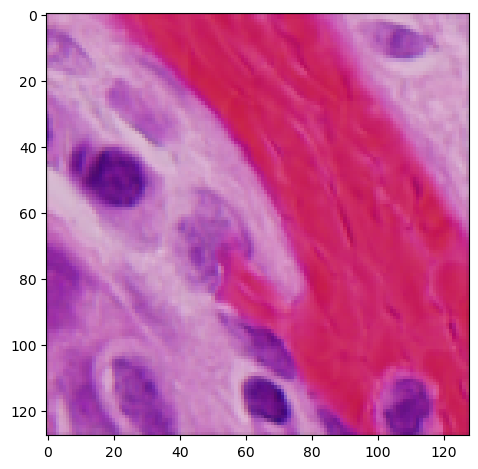

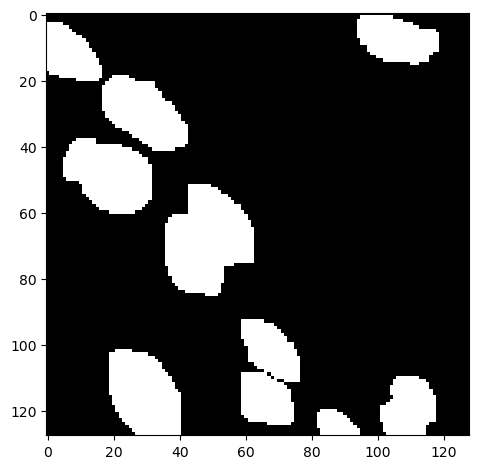

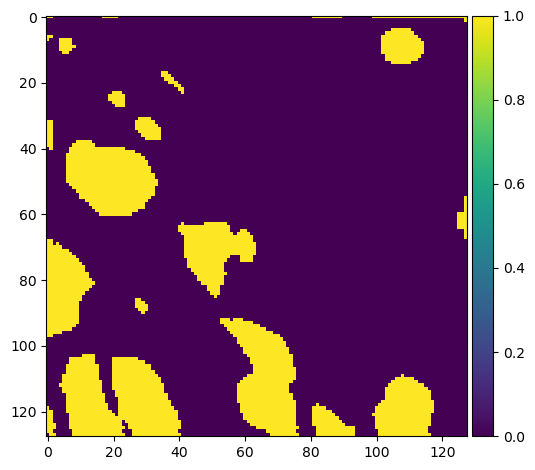

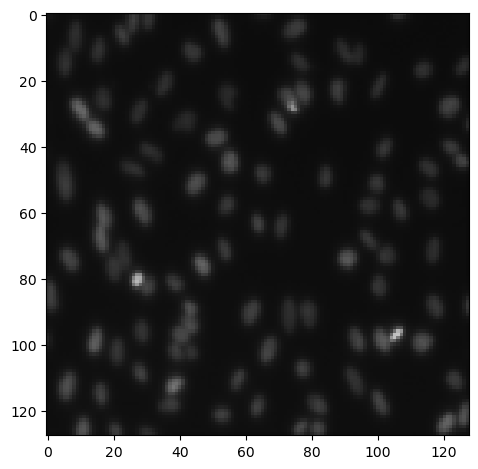

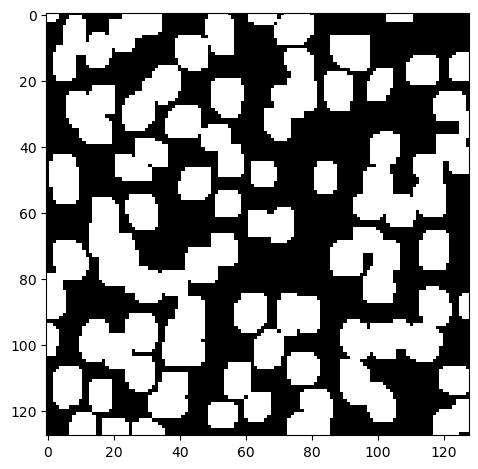

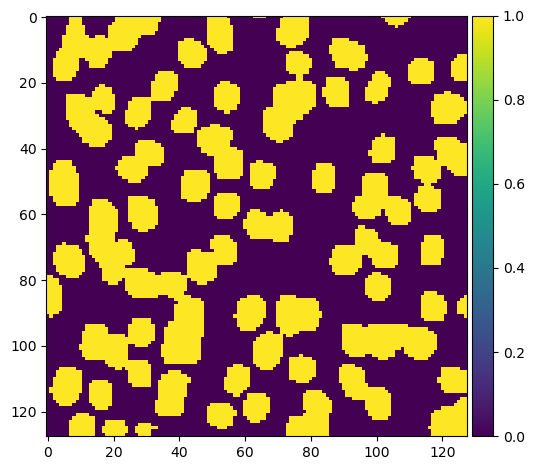

In [21]:
idx = random.randint(0, len(X_train))


preds_train = mod.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = mod.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = mod.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
